## Aggregate dynamics, stationary distribution and GE of a life-cycle economy

- author: Tao Wang
- this is a companion notebook to the paper "Perceived income risks"

In [1]:
import numpy as np
import pandas as pd
from interpolation import mlinterp
from numba import njit
from numba.typed import List
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
from Utility import make_grid_exp_mult
import scipy.optimize as op
from matplotlib import cm
import joypy
from copy import copy
from Utility import cal_ss_2markov,lorenz_curve,combine_ind_markov,gini
from Utility import mean_preserving_spread
from Utility import jump_to_grid, jump_to_grid_fast
from scipy import sparse 
import pickle

In [2]:
## figure plotting configurations


plt.style.use('seaborn')
plt.rcParams["font.family"] = "Times New Roman" #'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['axes.labelweight'] = 'bold'

## Set the 
plt.rc('font', size=25)
# Set the axes title font size
plt.rc('axes', titlesize=20)
# Set the axes labels font size
plt.rc('axes', labelsize=20)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=20)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=20)
# Set the legend font size
plt.rc('legend', fontsize=20)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)


### The Life-cycle Model Class and the Solver

In [3]:
from SolveLifeCycleBelief import LifeCycle, solve_model_backward_iter,compare_2solutions

### Initialize the model

In [4]:
from PrepareParameters import life_cycle_paras_q as lc_paras_Q
from PrepareParameters import life_cycle_paras_y as lc_paras_Y
## make a copy of the imported parameters 
lc_paras_y = copy(lc_paras_Y)
lc_paras_q = copy(lc_paras_Q)

In [5]:
## make some modifications 
P_ss = cal_ss_2markov(lc_paras_y['P_sub'])
lc_paras_y['σ_ψ_2mkv'] = np.sqrt(mean_preserving_spread(lc_paras_y['σ_ψ_sub'],P_ss,0.1))
lc_paras_y['σ_θ_2mkv'] = np.sqrt(mean_preserving_spread(lc_paras_y['σ_θ_sub'],P_ss,0.1))

In [6]:
print(lc_paras_y)

{'ρ': 2.0, 'β': 0.98, 'P': array([[0.18, 0.82],
       [0.04, 0.96]]), 'z_val': array([0., 1.]), 'σ_ψ': 0.15, 'σ_θ': 0.15, 'U': 0.0, 'LivPrb': 0.99375, 'R': 1.01, 'W': 1.0, 'T': 40, 'L': 60, 'G': array([1.02955663, 1.02707112, 1.02472198, 1.02250445, 1.02041411,
       1.01844633, 1.01659667, 1.01486087, 1.01323462, 1.01171374,
       1.01029408, 1.00897133, 1.00774169, 1.0066011 , 1.00554514,
       1.00457048, 1.00367308, 1.00284863, 1.00209379, 1.00140452,
       1.00077689, 1.00020754, 0.99969214, 0.99922734, 0.99880946,
       0.99843448, 0.99809891, 0.99779904, 0.99753112, 0.99729151,
       0.99707657, 0.9968825 , 0.99670583, 0.99654275, 0.99638963,
       0.996243  , 0.99609894, 0.99595392, 0.99580437, 0.99564648,
       0.81734119, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

Text(0, 0.5, '$\\hat Y$')

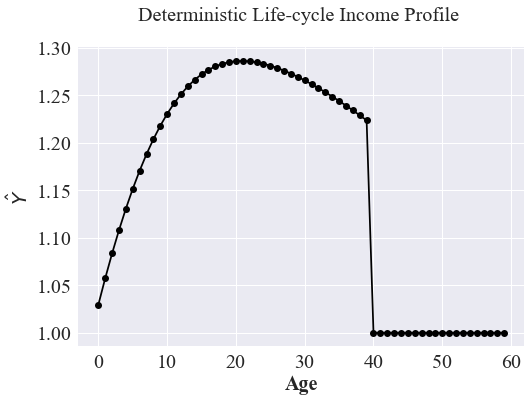

In [7]:
## a deterministic income profile 

## income profile 
YPath = np.cumprod(lc_paras_y['G'])

plt.title('Deterministic Life-cycle Income Profile \n')
plt.plot(YPath,'ko-')
plt.xlabel('Age')
plt.ylabel(r'$\hat Y$')

In [8]:
#this is a fake life cycle income function 

def fake_life_cycle(L):
    LPath = np.arange(L+1)
    Y_fake = -0.01*(LPath-int(L/3))**2+0.03*LPath+20
    G = Y_fake[1:]/Y_fake[:-1]
    return G

In [9]:
## parameters for testing 

U = 0.0 ## transitory ue risk 
LivPrb = 0.99
unemp_insurance = 0.15
sigma_psi = np.sqrt(0.01) # permanent 
sigma_eps = np.sqrt(0.04) # transitory 
sigma_p_init = np.sqrt(0.03)
init_b = 0.0
λ = 0.0942 
λ_SS = 0.0
transfer = 0.0
pension = 0.5

T = 40
L = 60
TGPos = int(L/2)
GPos = 1.01*np.ones(TGPos)
GNeg= 0.99*np.ones(L-TGPos)
#G = np.concatenate([GPos,GNeg])
#YPath = np.cumprod(G)
G = fake_life_cycle(L)
YPath = np.cumprod(G)

## other parameters 
ρ = 1
R = 1.01
W = 1.0
β = 0.96
x = 0.0

## no persistent state
b_y = 0.0

## set the bool to be true to turn on unemployment/employment markov (persistent unemployment risks)
ue_markov = True
###################################

## belief
P_sub = np.array([[0.5,0.5],
                  [0.5,0.5]])
## natural borrowing constraint if False
borrowing_cstr = True

## extrapolation parameter

theta = 0.0

## bequest ratio 
bequest_ratio = 0.0

### Solve the model with a Markov state: unemployment and employment 

In [10]:
## initialize a class of life-cycle model with either calibrated or test parameters 

#################################
calibrated_model = True
model_frequency = 'yearly'
#################################

if calibrated_model == True:

    if model_frequency=='yearly':
        ## yearly parameters 

        lc_paras = lc_paras_y

    elif model_frequency=='quarterly':
        ## yearly parameters 
        lc_paras = lc_paras_q


    ## initialize the model with calibrated parameters 
    lc_mkv = LifeCycle(
        ## primitives
                   ρ = lc_paras['ρ'],     ## relative risk aversion  
                   β = lc_paras['β'],     ## discount factor
                   borrowing_cstr = borrowing_cstr,
                   adjust_prob = 1.0,
        
        ## prices 
                   R = lc_paras['R'],           ## interest factor
                   W = lc_paras['W'],           ## Wage rate
        
        ## life cycle 
                   T = lc_paras['T'],
                   L = lc_paras['L'],
                   G = lc_paras['G'],
                   LivPrb = lc_paras['LivPrb'],       ## living probability 
        
        ## income risks 
                   x = 0.0,
                   b_y= 0.0,
                   sigma_psi = lc_paras['σ_ψ'],
                   sigma_eps = lc_paras['σ_θ'],
                   #subjective = True,
                   ue_markov = True,
                   P = lc_paras['P'],
                   U = lc_paras['U'],
                   z_val = lc_paras['z_val'], ## markov state from low to high 
                   
                   sigma_psi_true = lc_paras['σ_ψ'], ## true permanent
                   sigma_eps_true = lc_paras['σ_θ'], ## true transitory
        
        ## subjective 
                   P_sub = lc_paras['P_sub'],
                   sigma_psi_2mkv = lc_paras['σ_ψ_2mkv'],  ## permanent risks in 2 markov states
                   sigma_eps_2mkv = lc_paras['σ_θ_2mkv'],  ## transitory risks in 2 markov states
        
        ## initial conditions 
                    sigma_p_init = lc_paras['σ_ψ_init'],
                    init_b = lc_paras['init_b'],

        ## policy 
                   unemp_insurance = lc_paras['unemp_insurance'],
                   pension = lc_paras['pension'], ## pension
                   λ = lc_paras['λ'],  ## tax rate
                   λ_SS = lc_paras['λ_SS'], ## social tax rate
                   transfer = lc_paras['transfer'],  ## transfer 
                   bequest_ratio = lc_paras['bequest_ratio'],
        
         ## solutions 
                   shock_draw_size = 10.0,
                   grid_max = 10
                   )
    #print(lc_mkv.psi_shk_draws)
    #print(lc_mkv.eps_shk_draws)
    #print(lc_mkv.psi_shk_true_draws)
    #print(lc_mkv.eps_shk_true_draws)

    
    
    ## for the subjective model, only change the belief 

    lc_mkv_sub = LifeCycle(
        ## primitives
                   ρ = lc_paras['ρ'],     ## relative risk aversion  
                   β = lc_paras['β'],     ## discount factor
                   borrowing_cstr = borrowing_cstr,
                   adjust_prob = 1.0,
        ## prices 
                   R = lc_paras['R'],           ## interest factor
                   W = lc_paras['W'],            ## Wage rate
        ## life cycle 
                   T = lc_paras['T'],
                   L = lc_paras['L'],
                   G = lc_paras['G'],
                   LivPrb = lc_paras['LivPrb'],       ## living probability 
        
        ## income risks 
                   x = 0.0,
                   b_y= 0.0,
                   sigma_psi = lc_paras['σ_ψ_sub'],
                   sigma_eps = lc_paras['σ_θ_sub'],
                   subjective = True,
                   ue_markov = True,
                   P = lc_paras['P'],
                   U = lc_paras['U'],
                   z_val = lc_paras['z_val'], ## markov state from low to high
                   sigma_psi_true = lc_paras['σ_ψ'], ## true permanent
                   sigma_eps_true = lc_paras['σ_θ'], ## true transitory
        
        ## subjective 
        #############################################
                   state_dependent_belief = True,         ### allowing for markov belief state
                   P_sub = lc_paras['P_sub'],
                   sigma_psi_2mkv = lc_paras['σ_ψ_2mkv'],  ## permanent risks in 2 markov states
                   sigma_eps_2mkv = lc_paras['σ_θ_2mkv'],  ## transitory risks in 2 markov states
                   
        ## initial conditions 
                    sigma_p_init = lc_paras['σ_ψ_init'],
                    init_b = lc_paras['init_b'],

        ## policy 
                   unemp_insurance = lc_paras['unemp_insurance'],
                   pension = lc_paras['pension'], ## pension
                   λ = lc_paras['λ'],  ## tax rate
                   λ_SS = lc_paras['λ_SS'], ## social tax rate
                   transfer = lc_paras['transfer'],  ## transfer 
                   bequest_ratio = lc_paras['bequest_ratio'],
        ## solutions 
                  shock_draw_size =  10.0,
                  grid_max = 10
                   )
    
    #print(lc_mkv_sub.psi_shk_draws)
    #print(lc_mkv_sub.eps_shk_draws)
    #print(lc_mkv_sub.psi_shk_true_draws)
    #print(lc_mkv_sub.eps_shk_true_draws)
    
    
    ## no need to set bool to be true 
    lc_mkv_sub_true = LifeCycle(
        ## primitives
                   ρ = lc_paras['ρ'],     ## relative risk aversion  
                   β = lc_paras['β'],     ## discount factor
                   borrowing_cstr = borrowing_cstr,
                   adjust_prob = 1.0,
        ## prices 
                   R = lc_paras['R'],           ## interest factor
                   W = lc_paras['W'],            ## Wage rate
        ## life cycle 
                   T = lc_paras['T'],
                   L = lc_paras['L'],
                   G = lc_paras['G'],
                   LivPrb = lc_paras['LivPrb'],       ## living probability 
        
        ## income risks 
                   x = 0.0,
                   b_y = 0.0,
                   sigma_psi = lc_paras['σ_ψ_sub'],
                   sigma_eps = lc_paras['σ_θ_sub'],
                   subjective = False,
                   ue_markov = True,
                   P = lc_paras['P'],
                   U = lc_paras['U'],
                   z_val = lc_paras['z_val'], ## markov state from low to high
                   sigma_psi_true = lc_paras['σ_ψ_sub'], ## true permanent
                   sigma_eps_true = lc_paras['σ_θ_sub'], ## true transitory
        
        ## subjective 
        #######################################
                   state_dependent_belief = True,  
                   P_sub = lc_paras['P_sub'],
                   sigma_psi_2mkv = lc_paras['σ_ψ_2mkv'],  ## permanent risks in 2 markov states
                   sigma_eps_2mkv = lc_paras['σ_θ_2mkv'],  ## transitory risks in 2 markov states
        
        ## initial conditions 
                    sigma_p_init = lc_paras['σ_ψ_init'],
                    init_b = lc_paras['init_b'],

        ## policy 
                   unemp_insurance = lc_paras['unemp_insurance'],
                   pension = lc_paras['pension'], ## pension
                   λ = lc_paras['λ'],  ## tax rate
                   λ_SS = lc_paras['λ_SS'], ## social tax rate
                   transfer = lc_paras['transfer'],  ## transfer 
                   bequest_ratio = lc_paras['bequest_ratio'],
        ## solutions 
                  shock_draw_size =  10.0,
                  grid_max = 10
                   )
    
    #print(lc_mkv_sub_true.psi_shk_draws)
    #print(lc_mkv_sub_true.eps_shk_draws)
    #print(lc_mkv_sub_true.psi_shk_true_draws)
    #print(lc_mkv_sub_true.eps_shk_true_draws)
    
    
    lc_mkv_sub_cr = LifeCycle(
        ## primitives
                   ρ = lc_paras['ρ'],     ## relative risk aversion  
                   β = lc_paras['β'],     ## discount factor
                   borrowing_cstr = borrowing_cstr,
                   adjust_prob = 1.0,
        ## prices 
                   R = lc_paras['R'],           ## interest factor
                   W = lc_paras['W'],            ## Wage rate
        ## life cycle 
                   T = lc_paras['T'],
                   L = lc_paras['L'],
                   G = lc_paras['G'],
                   LivPrb = lc_paras['LivPrb'],       ## living probability 
        
        ## income risks 
                   x = 0.0,
                   b_y = 0.0,
                   sigma_psi = lc_paras['σ_ψ_sub'],
                   sigma_eps = lc_paras['σ_θ_sub'],
                   subjective = True,
                   ue_markov = True,
                   P = lc_paras['P'],
                   U = lc_paras['U'],
                   z_val = lc_paras['z_val'], ## markov state from low to high
                   sigma_psi_true = lc_paras['σ_ψ'], ## true permanent
                   sigma_eps_true = lc_paras['σ_θ'], ## true transitory
        
        ###########
                   state_dependent_risk = True,
        
        ## subjective 
                   P_sub = lc_paras['P_sub'],
                   sigma_psi_2mkv = lc_paras['σ_ψ_2mkv'],  ## permanent risks in 2 markov states
                   sigma_eps_2mkv = lc_paras['σ_θ_2mkv'],  ## transitory risks in 2 markov states
        
        ## initial conditions 
                    sigma_p_init = lc_paras['σ_ψ_init'],
                    init_b = lc_paras['init_b'],

        ## policy 
                   unemp_insurance = lc_paras['unemp_insurance'],
                   pension = lc_paras['pension'], ## pension
                   λ = lc_paras['λ'],  ## tax rate
                   λ_SS = lc_paras['λ_SS'], ## social tax rate
                   transfer = lc_paras['transfer'],  ## transfer 
                   bequest_ratio = lc_paras['bequest_ratio'],
        ## solutions 
                  shock_draw_size =  10.0,
                  grid_max = 10
                  )


else:
    ## only for testing 
    lc_mkv = LifeCycle(sigma_psi = sigma_psi,
                       sigma_eps = sigma_eps,
                       U=U,
                       LivPrb = LivPrb,
                       ρ=ρ,
                       R=R,
                       W=W,
                       G=G,
                       T=T,
                       L=L,
                       β=β,
                       x=x,  ## shut down ma(1)
                       theta=theta,
                       borrowing_cstr = borrowing_cstr,
                       b_y = b_y, ## set the macro state loading to be zero, it does not matter for ue_markov
                       unemp_insurance = unemp_insurance, 
                       pension = pension,
                       ue_markov = ue_markov,
                       sigma_p_init =sigma_p_init,
                       init_b = init_b,
                       λ = λ,
                       transfer = transfer,
                       bequest_ratio = bequest_ratio,
                       P_sub = P_sub
                      )
    
    lc_mkv_sub = LifeCycle(sigma_psi = 0.1*sigma_psi, ##  0.1 is arbitrary but just to make the PR lower
                       sigma_eps = 0.1*sigma_eps,
                       subjective = True,
                       sigma_psi_true = sigma_psi,
                       sigma_eps_true = sigma_eps,
                       U=U,
                       LivPrb = LivPrb,
                       ρ=ρ,
                       R=R,
                       W=W,
                       G=G,
                       T=T,
                       L=L,
                       β=β,
                       x=x,  ## shut down ma(1)
                       theta=theta,
                       borrowing_cstr = borrowing_cstr,
                       b_y = b_y, ## set the macro state loading to be zero, it does not matter for ue_markov
                       unemp_insurance = unemp_insurance, 
                       pension = pension,
                       ue_markov = ue_markov,
                       sigma_p_init =sigma_p_init,
                       init_b = init_b,
                       λ = λ,
                       transfer = transfer,
                       bequest_ratio = bequest_ratio
                      )
    
    lc_mkv_sub_true = LifeCycle(sigma_psi = 0.1*sigma_psi, ##  0.1 is arbitrary but just to make the PR lower
                       sigma_eps = 0.1*sigma_eps,
                       subjective =True,
                       sigma_psi_true = 0.1*sigma_psi,
                       sigma_eps_true = 0.1*sigma_eps,
                       U=U,
                       LivPrb = LivPrb,
                       ρ=ρ,
                       R=R,
                       W=W,
                       G=G,
                       T=T,
                       L=L,
                       β=β,
                       x=x,  ## shut down ma(1)
                       theta=theta,
                       borrowing_cstr = borrowing_cstr,
                       b_y = b_y, ## set the macro state loading to be zero, it does not matter for ue_markov
                       unemp_insurance = unemp_insurance, 
                       pension = pension,
                       ue_markov = ue_markov,
                       sigma_p_init =sigma_p_init,
                       init_b = init_b,
                       λ = λ,
                       transfer = transfer,
                       bequest_ratio = bequest_ratio
                      )
    lc_mkv_sub_cr = LifeCycle(sigma_psi = 0.1*sigma_psi, ##  0.1 is arbitrary but just to make the PR lower
                       sigma_eps = 0.1*sigma_eps,
                       subjective =True,
                       sigma_psi_true = sigma_psi,
                       sigma_eps_true = sigma_eps,
                       U=U,
                       LivPrb = LivPrb,
                       ρ=ρ,
                       R=R,
                       W=W,
                       G=G,
                       T=T,
                       L=L,
                       β=β,
                       x=x,  ## shut down ma(1)
                       theta=theta,
                       borrowing_cstr = borrowing_cstr,
                       b_y = b_y, ## set the macro state loading to be zero, it does not matter for ue_markov
                       unemp_insurance = unemp_insurance, 
                       pension = pension,
                       ue_markov = ue_markov,
                       sigma_p_init =sigma_p_init,
                       init_b = init_b,
                       λ = λ,
                       transfer = transfer,
                       bequest_ratio = bequest_ratio,
                       state_dependent_risk = True
                      )

reminder: needs to give true risk parameters: sigma_psi_true & sigma_eps_true!
reminder: needs to give true risk parameters: sigma_psi_true & sigma_eps_true!


In [11]:
## solve various models

models = [lc_mkv,
          lc_mkv_sub,
          lc_mkv_sub_true,
          #lc_mkv_sub_cr
         ]
specs = ['ob',
         'sub',
         'sub_true',
         #'cr'
        ]

model_names=['baseline',
             'SHPR',
             'HPR',
            # 'SLPR_sv'
            ]

ms_stars = []
σs_stars = []

t_start = time()
for i, model in enumerate(models):
    ## terminal solution
    m_init,σ_init = model.terminal_solution()

    ## solve backward
    ms_star, σs_star = solve_model_backward_iter(model,
                                                 m_init,
                                                 σ_init)
    ms_stars.append(ms_star)
    σs_stars.append(σs_star)

t_finish = time()

print("Time taken, in seconds: "+ str(t_finish - t_start))


Time taken, in seconds: 5.611129999160767


In [12]:
## be careful with the order 
## get the solution for the objective model 
ms_star_mkv, σs_star_mkv = ms_stars[0],σs_stars[0]

## get the solution for the subjective model 
ms_star_mkv_sub,σs_star_mkv_sub = ms_stars[1],σs_stars[1]

should be NEGATIVE!!!!!


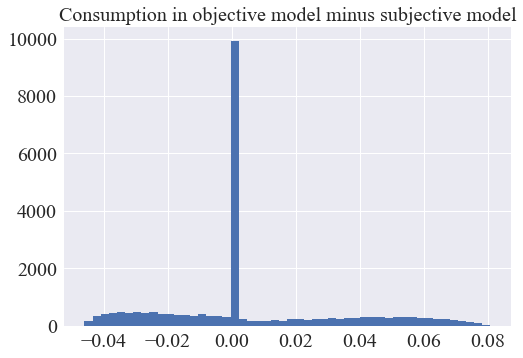

In [13]:
## compare different models 

ojb_minus_sub = compare_2solutions(ms_stars[0:2],
                                   σs_stars[0:2])

plt.hist(ojb_minus_sub.flatten(),
         bins=50)
plt.title('Consumption in objective model minus subjective model')
print('should be NEGATIVE!!!!!')

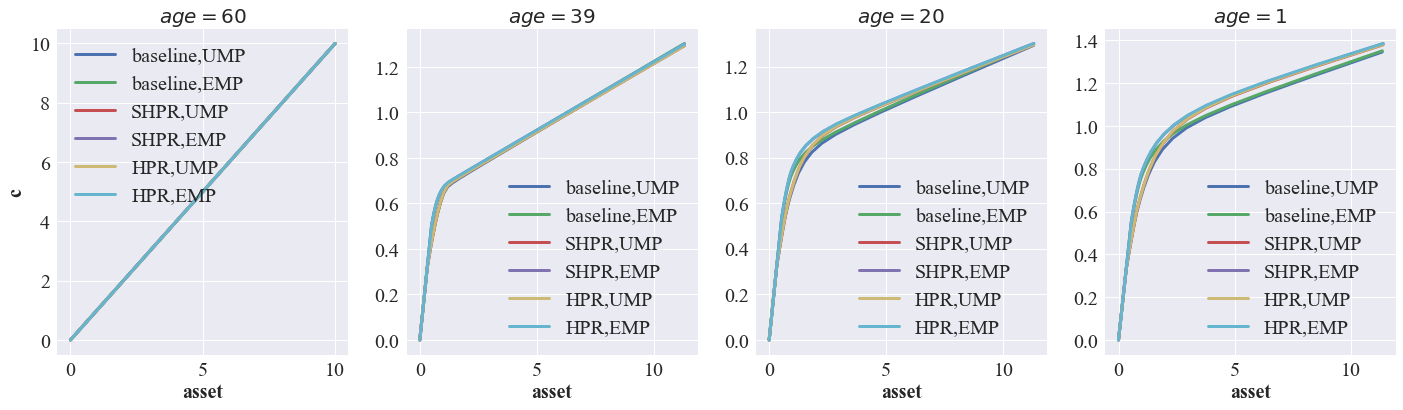

In [14]:
## compare solutions 

m_grid = np.linspace(0.0,10.0,200)
## plot c func at different age /asset grid
years_left = [0,21,40,59]

n_sub = len(years_left)

fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

for x,year in enumerate(years_left):
    age = lc_mkv.L-year
    i = lc_mkv.L-age
    z_l = 0
    z_h = 1
    for k,model_name in enumerate(model_names):
        if k<=3:
            m_plt_u_l,c_plt_u_l = ms_stars[k][i,:,0,z_l,0],σs_stars[k][i,:,0,z_l,0]
            m_plt_u_h,c_plt_u_h = ms_stars[k][i,:,0,z_l,1],σs_stars[k][i,:,0,z_l,1]
            m_plt_e_l,c_plt_e_l = ms_stars[k][i,:,0,z_h,0],σs_stars[k][i,:,0,z_h,0]
            m_plt_e_h,c_plt_e_h = ms_stars[k][i,:,0,z_h,1],σs_stars[k][i,:,0,z_h,1]
            #c_func_u = lambda m: interp(m_plt_u,c_plt_u,m)
            #c_func_e = lambda m: interp(m_plt_e,c_plt_e,m)
            axes[x].plot(m_plt_u_l,
                         c_plt_u_l,
                         label = model_name+',UMP',
                         lw=3
                        )
            axes[x].plot(m_plt_e_l,
                         c_plt_e_l,
                         label = model_name+',EMP',
                         lw=3
                        )
            
    axes[x].legend()
    #axes[x].set_xlim(0.0,np.max(m_plt_u))
    axes[x].set_xlabel('asset')
    axes[0].set_ylabel('c')
    axes[x].set_title(r'$age={}$'.format(age))

## Aggregate steady state distributions

In [15]:
from Utility import stationary_age_dist
## a function that computes social security tax rate balances gov budget for pension
from Utility import unemp_insurance2tax  
## a function that computes tax rate balances gov budget for ue insurance
from Utility import SS2tax
from Utility import CDProduction  
from PrepareParameters import production_paras_y as production_paras

In [19]:
#################################
## general functions used 
# for computing transition matrix
##################################

## compute the list of transition matrix from age t to t+1 for all age 

@njit
def calc_transition_matrix(model, 
                           ms_star, ## new,  life cycle age x asset x tran shock x z state grid 
                           σs_star, ## new, life cycle consumptiona t age  x asset x tran shock x z state grid 
                           dist_mGrid_list, ## new, list, grid of m for distribution 
                           dist_pGrid_list,  ## new, list, grid of p for distribution 
                           fast = False   ## new
                          ):
        '''
        Calculates how the distribution of agents across market resources 
        transitions from one period to the next. 
        If finite horizon problem, then calculates
        a list of transition matrices, consumption and asset policy grids for each period of the problem. 
        
        
        Parameters
        ----------
            # ms_star: array, sized of T x n_a x n_z x n_f, wealth grid 
            # σs_star: array, sized of T x n_a x n_z x n_f, consumption values at the grid
            # dist_mGrid_list, list, sized of 1, list of m grid sized of n_m
            # dist_pGrid_list, list, sized of T, list of permanent income grid for each age, sized of n_p
            # fast, bool, fast or slow method 

        Returns
        -------
            # tran_matrix_list, numba typed list, embedded list, sized of (n_z x n_f) x 1 ,
            ## each of which is sized of L, each of which is sized of n_m x n_p 
        
        '''         
        ## nb of states 
        state_num = len(model.P)
        
        ## unemployment insurance 
        unemp_insurance = model.unemp_insurance
        
        ## tax rate
        λ = model.λ
        λ_SS = model.λ_SS
        
        ## permanent income growth factor
        G = model.G
        
        ## grid holders
    
        aPol_Grid_u_f0_list = [] # List of asset policy grids for each period in T_cycle
        aPol_Grid_e_f0_list = [] # List of asset policy grids for each period in T_cycle
        aPol_Grid_u_f1_list = [] # List of asset policy grids for each period in T_cycle
        aPol_Grid_e_f1_list = [] # List of asset policy grids for each period in T_cycle

        tran_matrix_u_f0_list = [] # List of transition matrices
        tran_matrix_e_f0_list = [] # List of transition matrices
        tran_matrix_u_f1_list = [] # List of transition matrices
        tran_matrix_e_f1_list = [] # List of transition matrices

        #Obtain shocks and shock probabilities from income distribution in this period
        size_shk_probs  = len(model.eps_shk_true_draws)*len(model.psi_shk_true_draws)
        shk_prbs = np.ones(size_shk_probs)*1/size_shk_probs
        tran_shks = np.exp(np.repeat(model.eps_shk_true_draws,
                              len(model.psi_shk_true_draws)))
        perm_shks = np.exp(np.repeat(model.psi_shk_true_draws,
                              len(model.eps_shk_true_draws)))
                                 
        perm_shks_mkv0 = np.exp(np.repeat(model.psi_shk_mkv_draws[0,:],
                              len(model.psi_shk_true_draws)))
        

        perm_shks_mkv1 = np.exp(np.repeat(model.psi_shk_mkv_draws[1,:],
                              len(model.psi_shk_true_draws)))
                                 
        tran_shks_mkv0 = np.exp(np.repeat(model.eps_shk_mkv_draws[0,:],
                              len(model.psi_shk_true_draws)))
        
        tran_shks_mkv1 = np.exp(np.repeat(model.eps_shk_mkv_draws[1,:],
                              len(model.psi_shk_true_draws)))

        ## This is for the fast method 
        shk_prbs_ntrl =  np.multiply(shk_prbs,perm_shks)

        ## not used yet 
                        
        
                        
        for k in range(model.L): ## loop over agents at different ages, k
            
            age_id = k
            age = age_id + 1
            year_left = model.L-age
            
            markov_array2 = model.P
            markov_array2_sub = model.P_sub

            this_dist_pGrid = dist_pGrid_list[0] #If here then use prespecified permanent income grid
            ## m-grid does not depend on period             
            this_dist_mGrid = dist_mGrid_list[0]
            
            ## compute different c at different a and eps
            n_mgrid = len(this_dist_mGrid)
            
            Cnow_u_f0 = np.empty(n_mgrid,dtype = np.float64)
            Cnow_e_f0 = np.empty(n_mgrid,dtype = np.float64)
            Cnow_u_f1 = np.empty(n_mgrid,dtype = np.float64)
            Cnow_e_f1 = np.empty(n_mgrid,dtype = np.float64)

            
            for m_id,m in enumerate(this_dist_mGrid):
                fix_epsGrid = 1.0 ## can be anything because c is not a function of ep
                
                this_Cnow_u_f0 = mlinterp((ms_star[year_left,:,0,0,0],
                                           model.eps_grid),
                                       σs_star[year_left,:,:,0,0],
                                       (m,fix_epsGrid)) 
                Cnow_u_f0[m_id] = this_Cnow_u_f0
                
                this_Cnow_u_f1 = mlinterp((ms_star[year_left,:,0,0,1],   
                                        model.eps_grid),
                                       σs_star[year_left,:,:,0,1],
                                       (m,fix_epsGrid))  
                Cnow_u_f1[m_id] = this_Cnow_u_f1
                
                this_Cnow_e_f0 = mlinterp((ms_star[year_left,:,0,0,0],   
                                        model.eps_grid),
                                       σs_star[year_left,:,:,0,0],
                                       (m,fix_epsGrid)) 
                Cnow_e_f0[m_id] = this_Cnow_e_f0
                
                this_Cnow_e_f1 = mlinterp((ms_star[year_left,:,0,1,1],   
                                        model.eps_grid),
                                       σs_star[year_left,:,:,1,1],
                                       (m,fix_epsGrid)) 
                Cnow_e_f1[m_id] = this_Cnow_e_f1
                
            
            ## more generally, depending on the nb of markov states 
        
            aNext_u_f0 = this_dist_mGrid - Cnow_u_f0 # Asset policy grid in each age
            aNext_e_f0 = this_dist_mGrid - Cnow_e_f0 # Asset policy grid in each age
            aNext_u_f1 = this_dist_mGrid - Cnow_u_f1 # Asset policy grid in each age
            aNext_e_f1 = this_dist_mGrid - Cnow_e_f1 # Asset policy grid in each age
            
            aPol_Grid_u_f0_list.append(aNext_u_f0) # Add to list
            aPol_Grid_e_f0_list.append(aNext_e_f0) # Add to list
            aPol_Grid_u_f1_list.append(aNext_u_f1) # Add to list
            aPol_Grid_e_f1_list.append(aNext_e_f1) # Add to list

            bNext_u_f0 = model.R*aNext_u_f0
            bNext_e_f0 = model.R*aNext_e_f0
            bNext_u_f1 = model.R*aNext_u_f1
            bNext_e_f1 = model.R*aNext_e_f1

            
            if fast==True:  
                print('warning: the fast method is not fully developed yet!!!')
                
                # Generate Transition Matrix for u2u at belief state 0
                TranMatrix_u_f0_u = np.zeros((len(this_dist_mGrid),
                                          len(this_dist_mGrid)))
                if model.state_dependent_belief == False or model.subjective == True:
                    pass
                else:
                    perm_shks = perm_shks_mkv0
                    tran_shks = tran_shks_mkv0
                for i in range(len(this_dist_mGrid)):
                    if k <=model.T-1:
                        ## work age 
                        perm_shks_G = perm_shks*G[k+1]
                        mNext_ij = bNext_u_f0[i]/perm_shks_G +model.transfer+(1-λ)*unemp_insurance 
                    else:
                        ## retirement 
                        perm_shks_none = np.ones_like(perm_shks)*G[k+1]
                        mNext_ij = bNext_u_f0[i]/perm_shks_none +model.transfer+model.pension
                    
                    
                    if model.state_dependent_belief ==False or model.subjective == True:
                        pass
                    else:
                        shk_prbs_ntrl = np.multiply(shk_prbs,perm_shks_mkv0)


                    # Compute next period's market resources given todays bank balances bnext[i]
                    TranMatrix_u_f0_u[:,i] = jump_to_grid_fast(mNext_ij,
                                                           shk_prbs_ntrl,
                                                           this_dist_mGrid)
                    
                # Generate Transition Matrix for u2u at belief state 1
                TranMatrix_u_f1_u = np.zeros((len(this_dist_mGrid),
                                          len(this_dist_mGrid)))
                if model.state_dependent_belief ==False or model.subjective == True:
                    pass
                else:
                    perm_shks = perm_shks_mkv1
                    tran_shks = tran_shks_mkv1
                for i in range(len(this_dist_mGrid)):
                    if k <=model.T-1:
                        ## work age 
                        perm_shks_G = perm_shks*G[k+1]
                        mNext_ij = bNext_u_f1[i]/perm_shks_G +model.transfer+(1-λ)*unemp_insurance 
                    else:
                        ## retirement 
                        perm_shks_none = np.ones_like(perm_shks)*G[k+1]
                        mNext_ij = bNext_u_f1[i]/perm_shks_none +model.transfer+model.pension
                        
                    if model.state_dependent_belief==False or model.subjective == True:
                        pass
                    else:
                        shk_prbs_ntrl = np.multiply(shk_prbs,perm_shks_mkv1)
                        
                    # Compute next period's market resources given todays bank balances bnext[i]
                    TranMatrix_u_f1_u[:,i] = jump_to_grid_fast(mNext_ij,
                                                           shk_prbs_ntrl,
                                                           this_dist_mGrid)

                # Generate Transition Matrix for u2e for belief state 0
                TranMatrix_u_f0_e = np.zeros((len(this_dist_mGrid),
                                          len(this_dist_mGrid)))
                if model.state_dependent_belief ==False or model.subjective == True:
                    pass
                else:
                    perm_shks = perm_shks_mkv0
                    tran_shks = tran_shks_mkv0
                for i in range(len(this_dist_mGrid)):
                    if k <=model.T-1:
                        ## work age 
                        perm_shks_G = perm_shks*G[k+1]
                        mNext_ij = bNext_u_f0[i]/perm_shks_G +model.transfer+ (1-λ)*(1-λ_SS)*tran_shks  
                    else:
                        ## retirement 
                        perm_shks_none = np.ones_like(perm_shks)*G[k+1]
                        mNext_ij = bNext_u_f0[i]/perm_shks_none +model.transfer+model.pension
                        
                    if model.state_dependent_belief ==False or model.subjective == True:
                        pass
                    else:
                        shk_prbs_ntrl = np.multiply(shk_prbs,perm_shks_mkv0)
                    # Compute next period's market resources given today's bank balances bnext[i]
                    TranMatrix_u_f0_e[:,i] = jump_to_grid_fast(mNext_ij,
                                                            shk_prbs_ntrl,
                                                            this_dist_mGrid) 
                    
                # Generate Transition Matrix for u2e for belief state 1
                TranMatrix_u_f1_e = np.zeros((len(this_dist_mGrid),
                                          len(this_dist_mGrid))) 
                if model.state_dependent_belief ==False or model.subjective == True:
                    pass
                else:
                    perm_shks = perm_shks_mkv1
                    tran_shks = tran_shks_mkv1
                for i in range(len(this_dist_mGrid)):
                    if k <=model.T-1:
                        ## work age 
                        perm_shks_G = perm_shks*G[k+1]
                        mNext_ij = bNext_u_f1[i]/perm_shks_G +model.transfer+ (1-λ)*(1-λ_SS)*tran_shks  
                    else:
                        ## retirement 
                        perm_shks_none = np.ones_like(perm_shks)*G[k+1]
                        mNext_ij = bNext_u_f1[i]/perm_shks_none +model.transfer+model.pension
                    if model.state_dependent_belief==False or model.subjective == True:
                        pass
                    else:
                        shk_prbs_ntrl = np.multiply(shk_prbs,perm_shks_mkv1)
                    # Compute next period's market resources given today's bank balances bnext[i]
                    TranMatrix_u_f1_e[:,i] = jump_to_grid_fast(mNext_ij,
                                                            shk_prbs_ntrl,
                                                            this_dist_mGrid) 
                

                # Generate Transition Matrix for e2e for belief state 0 
                TranMatrix_e_f0_e = np.zeros((len(this_dist_mGrid),
                                          len(this_dist_mGrid)))
                if model.state_dependent_belief ==False or model.subjective == True:
                    pass
                else:
                    perm_shks = perm_shks_mkv0
                    tran_shks = tran_shks_mkv0
                for i in range(len(this_dist_mGrid)):
                    if k <=model.T-1:
                        ## work age 
                        perm_shks_G = perm_shks*G[k+1]
                        mNext_ij = bNext_e_f0[i]/perm_shks_G +model.transfer+ (1-λ)*(1-λ_SS)*tran_shks # Compute next period's market resources given today's bank balances bnext[i]
                    else:
                        ## retirement 
                        perm_shks_none = np.ones_like(perm_shks)*G[k+1]
                        mNext_ij = bNext_e_f0[i]/perm_shks_none +model.transfer+model.pension
                    if model.state_dependent_belief ==False or model.subjective == True:
                        pass
                    else:
                        shk_prbs_ntrl = np.multiply(shk_prbs,perm_shks_mkv0)
                    TranMatrix_e_f0_e[:,i] = jump_to_grid_fast(mNext_ij,
                                                          shk_prbs_ntrl,
                                                          this_dist_mGrid)
                    
                # Generate Transition Matrix for e2e for belief state 1
                TranMatrix_e_f1_e = np.zeros((len(this_dist_mGrid),
                                          len(this_dist_mGrid)))
                if model.state_dependent_belief ==False or model.subjective == True:
                    pass
                else:
                    perm_shks = perm_shks_mkv1
                    tran_shks = tran_shks_mkv1
                for i in range(len(this_dist_mGrid)):
                    if k <=model.T-1:
                        ## work age 
                        perm_shks_G = perm_shks*G[k+1]
                        mNext_ij = bNext_e_f1[i]/perm_shks_G +model.transfer+ (1-λ)*(1-λ_SS)*tran_shks # Compute next period's market resources given today's bank balances bnext[i]
                    else:
                        ## retirement 
                        perm_shks_none = np.ones_like(perm_shks)*G[k+1]
                        mNext_ij = bNext_e_f1[i]/perm_shks_none +model.transfer+model.pension
                        
                    if model.state_dependent_belief==False or model.subjective == True:
                        pass
                    else:
                        shk_prbs_ntrl = np.multiply(shk_prbs,perm_shks_mkv1)
                    TranMatrix_e_f1_e[:,i] = jump_to_grid_fast(mNext_ij,
                                                          shk_prbs_ntrl,
                                                          this_dist_mGrid)

                # Generate Transition Matrix for e2u for belief state 0 
                TranMatrix_e_f0_u = np.zeros((len(this_dist_mGrid),
                                          len(this_dist_mGrid)))
                if model.state_dependent_belief ==False or model.subjective == True:
                    pass
                else:
                    perm_shks = perm_shks_mkv0
                    tran_shks = tran_shks_mkv0
                for i in range(len(this_dist_mGrid)):
                    if k <=model.T-1:
                        ## work age 
                        perm_shks_G = perm_shks*G[k+1]
                        mNext_ij = bNext_e_f0[i]/perm_shks_G +model.transfer+ (1-λ)*unemp_insurance # Compute next period's market resources given today's bank balances bnext[i]
                    else:
                        ## retirement
                        perm_shks_none = np.ones_like(perm_shks)*G[k+1]
                        mNext_ij = bNext_e_f0[i]/perm_shks_none +model.transfer+ model.pension
                    if model.state_dependent_belief==False or model.subjective == True:
                        pass
                    else:
                        shk_prbs_ntrl = np.multiply(shk_prbs,perm_shks_mkv0)
                    TranMatrix_e_f0_u[:,i] = jump_to_grid_fast(mNext_ij,
                                                           shk_prbs_ntrl,
                                                            this_dist_mGrid) 
                    
            # Generate Transition Matrix for e2u for belief state 1 
                TranMatrix_e_f1_u = np.zeros((len(this_dist_mGrid),
                                          len(this_dist_mGrid))) 
                if model.state_dependent_belief ==False or model.subjective == True:
                    pass
                else:
                    perm_shks = perm_shks_mkv1
                    tran_shks = tran_shks_mkv1
                for i in range(len(this_dist_mGrid)):
                    if k <=model.T-1:
                        ## work age 
                        perm_shks_G = perm_shks*G[k+1]
                        mNext_ij = bNext_e_f1[i]/perm_shks_G +model.transfer+ (1-λ)*unemp_insurance # Compute next period's market resources given today's bank balances bnext[i]
                    else:
                        ## retirement
                        perm_shks_none = np.ones_like(perm_shks)*G[k+1]
                        mNext_ij = bNext_e_f1[i]/perm_shks_none +model.transfer+ model.pension
                    if model.state_dependent_belief==False or model.subjective == True:
                        pass
                    else:
                        shk_prbs_ntrl = np.multiply(shk_prbs,perm_shks_mkv1)
                    TranMatrix_e_f1_u[:,i] = jump_to_grid_fast(mNext_ij,
                                                           shk_prbs_ntrl,
                                                            this_dist_mGrid)


            else:  ## slow method  (2-state Markov implemented)


                # Generate Transition Matrix for u2u for belief state 0 
                TranMatrix_u_f0_u = np.zeros((len(this_dist_mGrid)*len(this_dist_pGrid),
                                       len(this_dist_mGrid)*len(this_dist_pGrid))) 
                if model.state_dependent_belief ==False or model.subjective == True:
                    pass
                else:
                    perm_shks = perm_shks_mkv0
                    tran_shks = tran_shks_mkv0
                    
                for i in range(len(this_dist_mGrid)):
                    for j in range(len(this_dist_pGrid)):
                        
                        pNext_ij = this_dist_pGrid[j]*perm_shks_mkv0*G[k+1] # Computes next period's permanent income level by applying permanent income shock

                        if k <=model.T-1:
                            perm_shks_G = perm_shks* G[k+1]
                            ## work age 
                            mNext_ij = bNext_u_f0[i]/perm_shks_G +model.transfer+ (1-λ)*(1-λ_SS)*unemp_insurance # Compute next period's market resources given today's bank balances bnext[i]
                        else:
                            perm_shks_none = np.ones_like(perm_shks)*G[k+1]
                            ## retirement
                            mNext_ij = bNext_u_f0[i]/perm_shks_none +model.transfer+ model.pension

                        TranMatrix_u_f0_u[:,i*len(this_dist_pGrid)+j] = jump_to_grid(mNext_ij,
                                                                                 pNext_ij,
                                                                                 shk_prbs,
                                                                                 this_dist_mGrid, 
                                                                                this_dist_pGrid) 
                #TranMatrix = TranMatrix #columns represent the current state while rows represent the next state
                #the 4th row , 6th column entry represents the probability of transitioning from the 6th element of the combined perm and m grid (grid of market resources multiplied by grid of perm income) to the 4th element of the combined perm and m grid
                #tran_matrix_list.append(TranMatrix_uu)
                
                
                # Generate Transition Matrix for u2u for belief state 1 
                TranMatrix_u_f1_u = np.zeros((len(this_dist_mGrid)*len(this_dist_pGrid),
                                       len(this_dist_mGrid)*len(this_dist_pGrid))) 
                if model.state_dependent_belief==False or model.subjective == True:
                    pass
                else:
                    perm_shks = perm_shks_mkv1
                    tran_shks = tran_shks_mkv1
                for i in range(len(this_dist_mGrid)):
                    for j in range(len(this_dist_pGrid)):
                        pNext_ij = this_dist_pGrid[j]*perm_shks*G[k+1] # Computes next period's permanent income level by applying permanent income shock
                        if k <=model.T-1:
                            perm_shks_G = perm_shks* G[k+1]
                            ## work age 
                            mNext_ij = bNext_u_f1[i]/perm_shks_G +model.transfer+ (1-λ)*(1-λ_SS)*unemp_insurance # Compute next period's market resources given today's bank balances bnext[i]
                        else:
                            perm_shks_none = np.ones_like(perm_shks)*G[k+1]
                            ## retirement
                            mNext_ij = bNext_u_f1[i]/perm_shks_none +model.transfer+ model.pension

                        TranMatrix_u_f1_u[:,i*len(this_dist_pGrid)+j] = jump_to_grid(mNext_ij,
                                                                                 pNext_ij,
                                                                                 shk_prbs,
                                                                                 this_dist_mGrid, 
                                                                                this_dist_pGrid)
                
    
                # Generate Transition Matrix for u2e for belief state 0
                TranMatrix_u_f0_e = np.zeros((len(this_dist_mGrid)*len(this_dist_pGrid),
                                       len(this_dist_mGrid)*len(this_dist_pGrid))) 
                if model.state_dependent_belief==False or model.subjective == True:
                    pass
                else:
                    perm_shks = perm_shks_mkv0
                    tran_shks = tran_shks_mkv0
                    
                for i in range(len(this_dist_mGrid)):
                    for j in range(len(this_dist_pGrid)):
                        pNext_ij = this_dist_pGrid[j]*perm_shks*G[k+1] # Computes next period's permanent income level by applying permanent income shock
                        if k <=model.T-1:
                            ## work age 
                            perm_shks_G = perm_shks* G[k+1]
                            mNext_ij = bNext_u_f0[i]/perm_shks_G +model.transfer+ (1-λ)*(1-λ_SS)*tran_shks # Compute next period's market resources given today's bank balances bnext[i]
                        else:
                            ## retirement
                            perm_shks_none = np.ones_like(perm_shks)*G[k+1]
                            mNext_ij = bNext_u_f0[i]/perm_shks_none +model.transfer+ model.pension
                        TranMatrix_u_f0_e[:,i*len(this_dist_pGrid)+j] = jump_to_grid(mNext_ij,
                                                                               pNext_ij, 
                                                                               shk_prbs, 
                                                                               this_dist_mGrid, 
                                                                               this_dist_pGrid)
                        
                # Generate Transition Matrix for u2e for belief state 1
                TranMatrix_u_f1_e = np.zeros((len(this_dist_mGrid)*len(this_dist_pGrid),
                                       len(this_dist_mGrid)*len(this_dist_pGrid))) 
                if model.state_dependent_belief==False or model.subjective == True:
                    pass
                else:
                    perm_shks = perm_shks_mkv1
                    tran_shks = tran_shks_mkv1
                for i in range(len(this_dist_mGrid)):
                    for j in range(len(this_dist_pGrid)):
                        pNext_ij = this_dist_pGrid[j]*perm_shks*G[k+1] # Computes next period's permanent income level by applying permanent income shock
                        if k <=model.T-1:
                            ## work age 
                            perm_shks_G = perm_shks* G[k+1]
                            mNext_ij = bNext_u_f1[i]/perm_shks_G +model.transfer+ (1-λ)*(1-λ_SS)*tran_shks # Compute next period's market resources given today's bank balances bnext[i]
                        else:
                            ## retirement
                            perm_shks_none = np.ones_like(perm_shks)*G[k+1]
                            mNext_ij = bNext_u_f1[i]/perm_shks_none +model.transfer+ model.pension
                        TranMatrix_u_f1_e[:,i*len(this_dist_pGrid)+j] = jump_to_grid(mNext_ij,
                                                                               pNext_ij, 
                                                                               shk_prbs, 
                                                                               this_dist_mGrid, 
                                                                               this_dist_pGrid) 
                        
                # Generate Transition Matrix for e2u for belief state 0
                TranMatrix_e_f0_u = np.zeros((len(this_dist_mGrid)*len(this_dist_pGrid),
                                       len(this_dist_mGrid)*len(this_dist_pGrid))) 
                if model.state_dependent_belief==False or model.subjective == True:
                    pass
                else:
                    perm_shks = perm_shks_mkv0
                    tran_shks = tran_shks_mkv0
                for i in range(len(this_dist_mGrid)):
                    for j in range(len(this_dist_pGrid)):
                        pNext_ij = this_dist_pGrid[j]*perm_shks*G[k+1] # Computes next period's permanent income level by applying permanent income shock

                        if k <=model.T-1:
                            ## work age 
                            perm_shks_G = perm_shks* G[k+1]
                            mNext_ij = bNext_e_f0[i]/perm_shks_G +model.transfer+ (1-λ)*unemp_insurance # Compute next period's market resources given today's bank balances bnext[i]
                        else:
                            ## retirement
                            perm_shks_none = np.ones_like(perm_shks)*G[k+1]
                            mNext_ij = bNext_e_f0[i]/perm_shks_none +model.transfer+ model.pension
                        TranMatrix_e_f0_u[:,i*len(this_dist_pGrid)+j] = jump_to_grid(mNext_ij,
                                                                                   pNext_ij, 
                                                                                   shk_prbs, 
                                                                                   this_dist_mGrid, 
                                                                                   this_dist_pGrid)
                
                # Generate Transition Matrix for e2u for belief state 1
                TranMatrix_e_f1_u = np.zeros((len(this_dist_mGrid)*len(this_dist_pGrid),
                                       len(this_dist_mGrid)*len(this_dist_pGrid))) 
                if model.state_dependent_belief ==False or model.subjective == True:
                    pass
                else:
                    perm_shks = perm_shks_mkv1
                    tran_shks = tran_shks_mkv1
                for i in range(len(this_dist_mGrid)):
                    for j in range(len(this_dist_pGrid)):
                        pNext_ij = this_dist_pGrid[j]*perm_shks*G[k+1] # Computes next period's permanent income level by applying permanent income shock

                        if k <=model.T-1:
                            ## work age 
                            perm_shks_G = perm_shks* G[k+1]
                            mNext_ij = bNext_e_f1[i]/perm_shks_G +model.transfer+ (1-λ)*unemp_insurance # Compute next period's market resources given today's bank balances bnext[i]
                        else:
                            ## retirement
                            perm_shks_none = np.ones_like(perm_shks)*G[k+1]
                            mNext_ij = bNext_e_f1[i]/perm_shks_none +model.transfer+ model.pension
                        TranMatrix_e_f1_u[:,i*len(this_dist_pGrid)+j] = jump_to_grid(mNext_ij,
                                                                                   pNext_ij, 
                                                                                   shk_prbs, 
                                                                                   this_dist_mGrid, 
                                                                                   this_dist_pGrid)
                        
                # Generate Transition Matrix for e2e for belief state 0 
                TranMatrix_e_f0_e = np.zeros((len(this_dist_mGrid)*len(this_dist_pGrid),
                                       len(this_dist_mGrid)*len(this_dist_pGrid))) 
                if model.state_dependent_belief==False or model.subjective == True:
                    pass
                else:
                    perm_shks = perm_shks_mkv0
                    tran_shks = tran_shks_mkv0
                for i in range(len(this_dist_mGrid)):
                    for j in range(len(this_dist_pGrid)):
                        
                        pNext_ij = this_dist_pGrid[j]*perm_shks*G[k+1] # Computes next period's permanent income level by applying permanent income shock
                        if k <=model.T-1:
                            perm_shks_G = perm_shks*G[k+1]
                            mNext_ij = bNext_e_f0[i]/perm_shks_G +model.transfer+(1-λ)*(1-λ_SS)*tran_shks # Compute next period's market resources given today's bank balances bnext[i]
                        else:
                            ## retirement
                            perm_shks_none = np.ones_like(perm_shks)*G[k+1]
                            mNext_ij = bNext_e_f0[i]/perm_shks_none +model.transfer+model.pension
                        TranMatrix_e_f0_e[:,i*len(this_dist_pGrid)+j] = jump_to_grid(mNext_ij,
                                                                               pNext_ij, 
                                                                               shk_prbs, 
                                                                               this_dist_mGrid, 
                                                                               this_dist_pGrid)
                        
                        
            # Generate Transition Matrix for e2e for belief state 1 
                TranMatrix_e_f1_e = np.zeros((len(this_dist_mGrid)*len(this_dist_pGrid),
                                       len(this_dist_mGrid)*len(this_dist_pGrid))) 
                if model.state_dependent_belief==False or model.subjective == True:
                    pass
                else:
                    perm_shks = perm_shks_mkv1
                    tran_shks = tran_shks_mkv1
                for i in range(len(this_dist_mGrid)):
                    for j in range(len(this_dist_pGrid)):
                        pNext_ij = this_dist_pGrid[j]*perm_shks*G[k+1] # Computes next period's permanent income level by applying permanent income shock
                        if k <=model.T-1:
                            perm_shks_G = perm_shks*G[k+1]
                            mNext_ij = bNext_e_f1[i]/perm_shks_G +model.transfer+(1-λ)*(1-λ_SS)*tran_shks # Compute next period's market resources given today's bank balances bnext[i]
                        else:
                            ## retirement
                            perm_shks_none = np.ones_like(perm_shks)*G[k+1]
                            mNext_ij = bNext_e_f1[i]/perm_shks_none +model.transfer+model.pension
                        TranMatrix_e_f1_e[:,i*len(this_dist_pGrid)+j] = jump_to_grid(mNext_ij,
                                                                               pNext_ij, 
                                                                               shk_prbs, 
                                                                               this_dist_mGrid, 
                                                                               this_dist_pGrid)

                        
        ###################################################
        ## back from the fork between slow and fast method 
        ##################################################
        ## transition matrix for each markov state 
            tran_matrix_u_f0 = markov_array2[0,1] * TranMatrix_u_f0_e  + markov_array2[0,0]* TranMatrix_u_f0_u #This is the transition for someone who's state today is unemployed
            tran_matrix_e_f0 = markov_array2[1,1]*TranMatrix_e_f0_e  +  markov_array2[1,0] * TranMatrix_e_f0_u # This is the transition for someone who's state is employed today
            tran_matrix_u_f1 = markov_array2[0,1] * TranMatrix_u_f1_e  + markov_array2[0,0]* TranMatrix_u_f1_u
            tran_matrix_e_f1 = markov_array2[1,1]*TranMatrix_e_f1_e  +  markov_array2[1,0] * TranMatrix_e_f1_u
                
            ## merge to the life cycle list 
            tran_matrix_u_f0_list.append( tran_matrix_u_f0 ) #This is the transition for someone who's state today is unemployed
            tran_matrix_e_f0_list.append( tran_matrix_e_f0 )
            tran_matrix_u_f1_list.append( tran_matrix_u_f1 )
            tran_matrix_e_f1_list.append( tran_matrix_e_f1 )
        
        ## append over all ages 
        tran_matrix_list = List([tran_matrix_u_f0_list,
                                 tran_matrix_e_f0_list,
                                tran_matrix_u_f1_list,
                                 tran_matrix_e_f1_list,])
        
        ## return aggregate transition matrix and 
        ###.   the age/state dependent transition matrices necessary for computing aggregate consumption
        
        
        ## consumption policy and saving grid on each m, p, z and k grid 
     
        aPol_Grid_list = List([aPol_Grid_u_f0_list,
                               aPol_Grid_e_f0_list,
                              aPol_Grid_u_f1_list,
                               aPol_Grid_e_f1_list]) ## list of consumption 
        
        
        return tran_matrix_list, aPol_Grid_list #!cPol_Grid_list

@njit
def initial_distribution_u(model,
                         dist_mGrid, ## new, array, grid of m for distribution 
                         dist_pGrid,  ## new, array, grid of p for distribution 
                        ):
    ## get the distribution of p after shocks 
    init_p_plus_shk_draws = np.sort(
        np.array(
            [np.exp(init_p) * np.exp(psi_shk) 
             for init_p in model.init_p_draws 
             for psi_shk in model.psi_shk_draws
            ]
        )
    )
    init_p_plus_shk_probs = np.ones(len(init_p_plus_shk_draws))/len(init_p_plus_shk_draws)
    shk_prbs = np.repeat(
        init_p_plus_shk_probs,
        len(model.eps_shk_draws)
    )*1/len(model.eps_shk_draws)
    
    λ = model.λ
    init_b = model.init_b
    ue_insurance = np.repeat(np.ones_like(model.eps_shk_draws),
                          len(init_p_plus_shk_probs))*model.unemp_insurance  
    init_p_draws = np.exp(np.repeat(init_p_plus_shk_draws,
                          len(model.eps_shk_draws)))
    
    ## this function starts with a state-specific initial distribution over m and p as a vector sized of (n_m x n_p) 
    NewBornDist = jump_to_grid(np.ones_like(init_p_draws)*((1-λ)*ue_insurance+init_b/init_p_draws+model.transfer), ## initial unemployment insurance and accidental bequest transfer
                               init_p_draws,
                               shk_prbs,
                               dist_mGrid,
                               dist_pGrid)
    return NewBornDist

@njit
def initial_distribution_e(model,
                         dist_mGrid, ## new, array, grid of m for distribution 
                         dist_pGrid,  ## new, array, grid of p for distribution 
                        ):
    ## get the distribution of p after shocks 
    init_p_plus_shk_draws = np.sort(
        np.array(
            [np.exp(init_p) * np.exp(psi_shk) 
             for init_p in model.init_p_draws 
             for psi_shk in model.psi_shk_draws
            ]
        )
    )
    init_p_plus_shk_probs = np.ones(len(init_p_plus_shk_draws))/len(init_p_plus_shk_draws)
    shk_prbs = np.repeat(
        init_p_plus_shk_probs,
        len(model.eps_shk_draws)
    )*1/len(model.eps_shk_draws)
    
    λ = model.λ
    λ_SS = model.λ_SS
    init_b = model.init_b
    
    tran_shks = np.exp(np.repeat(model.eps_shk_draws,
                          len(init_p_plus_shk_probs)))
    init_p_draws = np.exp(np.repeat(init_p_plus_shk_draws,
                          len(model.eps_shk_draws)))
    ## this function starts with a state-specific initial distribution over m and p as a vector sized of (n_m x n_p) 
    NewBornDist = jump_to_grid((1-λ)*(1-λ_SS)*tran_shks+init_b/init_p_draws+model.transfer, ## initial transitory risks and accidental bequest transfer
                               init_p_draws,
                               shk_prbs,
                               dist_mGrid,
                               dist_pGrid)
    return NewBornDist

def AggregateDist(dist_lists,  ## size of nb markov state, each of which is sized model.L, each of which is sized n_m x n_p
              mp_pdfs_lists,  ## list of pdfs of over m and p grids given markov state and age
              mkv_dist, 
              age_dist):      ## distribution over ages
    X = 0.0
    for zf in range(len(mkv_dist)):
        for k in range(len(age_dist)):
            x_flat = dist_lists[zf][k].flatten()
            pdf_flat = mp_pdfs_lists[zf][k].flatten()
            X+= np.dot(x_flat,pdf_flat)*age_dist[k]*mkv_dist[zf]
    return X

## get the single vector of distribution 

def flatten_dist(grid_lists,      ## (nb.z x nb.f) x L x nb x nm x np
                 mp_pdfs_lists,   ## (nb.z x nb.f) x L x nb x nm x np 
                 dstn,            ## size of (nb.z x nb.f)
                 age_dist):       ## size of L 
    mp_pdfs_lists_new = []
    
    for zf in range(len(dstn)):
        for k in range(len(age_dist)):
            this_pdfs_lists = mp_pdfs_lists[zf][k]*dstn[zf]*age_dist[k]
            mp_pdfs_lists_new.append(this_pdfs_lists)
    grid_sort_id = np.array(grid_lists).flatten().argsort()
    grid_array = np.array(grid_lists).flatten()[grid_sort_id]
    mp_pdfs_array = np.array(mp_pdfs_lists_new).flatten()[grid_sort_id]
    return grid_array, mp_pdfs_array


In [20]:
class HH_OLG_Markov:
    """
    A class that deals with distributions of the household (HH) block
    """

    def __init__(self,
                 model = None):  

        self.model = model
        
        self.age_dist = stationary_age_dist(model.L,
                                            n = 0.0,
                                            LivPrb = model.LivPrb)
        
        ## ss distribution of emp uemp states 
        self.ss_dstn = cal_ss_2markov(model.P)
        self.ss_dstn_combined = combine_ind_markov([cal_ss_2markov(model.P),
                                                    cal_ss_2markov(model.P_sub)])
        
    ## create distribution grid points 
    def define_distribution_grid(self,
                                 dist_mGrid = None, 
                                 dist_pGrid = None, 
                                 m_density = 0, 
                                 num_pointsM = 48,  
                                 num_pointsP = 50, 
                                 max_p_fac = 20.0):

            '''
            Defines the grid on which the distribution is defined. Stores the grid of market resources and permanent income as attributes of self.
            Grid for normalized market resources and permanent income may be prespecified 
            as dist_mGrid and dist_pGrid, respectively. If not then default grid is computed based off given parameters.

            Parameters
            ----------
            dist_mGrid : np.array
                    Prespecified grid for distribution over normalized market resources

            dist_pGrid : np.array
                    Prespecified grid for distribution over permanent income. 

            m_density: float
                    Density of normalized market resources grid. Default value is mdensity = 0.
                    Only affects grid of market resources if dist_mGrid=None.

            num_pointsM: float
                    Number of gridpoints for market resources grid.

            num_pointsP: float
                     Number of gridpoints for permanent income. 
                     This grid will be exponentiated by the function make_grid_exp_mult.

            max_p_fac : float
                    Factor that scales the maximum value of permanent income grid. 
                    Larger values increases the maximum value of permanent income grid.

            Returns
            -------
            List(dist_mGrid): numba typed list, sized of 1, each of which is sized n_m
            List(dist_pGrid): numba typed list, sized of T, each of which is sized n_p
            '''  
            
            ## model
            
            model = self.model 
            
            ## m distribution grid 
            if dist_mGrid == None:
                aXtra_Grid = make_grid_exp_mult(ming = model.a_grid[0], 
                                                maxg = model.a_grid[-1], 
                                                ng = num_pointsM, 
                                                timestonest = 3) #Generate Market resources grid given density and number of points

                for i in range(m_density):
                    axtra_shifted = np.delete(aXtra_Grid,-1) 
                    axtra_shifted = np.insert(axtra_shifted, 0,1.00000000e-04)
                    dist_betw_pts = aXtra_Grid - axtra_shifted
                    dist_betw_pts_half = dist_betw_pts/2
                    new_A_grid = axtra_shifted + dist_betw_pts_half
                    aXtra_Grid = np.concatenate((aXtra_Grid,new_A_grid))
                    aXtra_Grid = np.sort(aXtra_Grid)

                dist_mGrid =  [aXtra_Grid]

            else:
                dist_mGrid = [dist_mGrid] #If grid of market resources prespecified then use as mgrid

            ## permanent distribution grid 
            if dist_pGrid == None:
                dist_pGrid = [] #list of grids of permanent income    

                for i in range(model.L):
                    #Dist_pGrid is taken to cover most of the ergodic distribution
                    if model.sigma_psi!=0.0:
                        std_p = model.sigma_psi
                    else:
                        std_p = 1e-2
                    max_p = max_p_fac*std_p*(1/(1-model.LivPrb))**0.5 # Consider probability of staying alive this period
                    right_sided_grid = make_grid_exp_mult(1.05+1e-3, np.exp(max_p), num_pointsP, 2)
                    left_sided_gird = np.append(1.0/np.fliplr([right_sided_grid])[0],np.ones(1))
                    left_sided_gird = 1.0/np.fliplr([right_sided_grid])[0]
                    this_dist_pGrid = np.append(left_sided_gird,
                                                right_sided_grid) # Compute permanent income grid this period. Grid of permanent income may differ dependent on PermShkStd
                    dist_pGrid.append(this_dist_pGrid)

            else:
                dist_pGrid = [dist_pGrid] #If grid of permanent income prespecified then use as pgrid
                
            self.m_dist_grid_list = List(dist_mGrid)
            self.p_dist_grid_list = List(dist_pGrid)

            
    ## get the distributions of each age by iterating forward over life cycle 

    def ComputeSSDist(self,
              ms_star = None,
              σs_star = None):
        
        model = self.model
        m_dist_grid_list = self.m_dist_grid_list
        p_dist_grid_list = self.p_dist_grid_list
        ss_dstn_combined = self.ss_dstn_combined
        age_dist = self.age_dist
        
        
        time_start = time()

        ## get the embedded list sized (n_z x n_f)x L x n_m x n_p

        tran_matrix_lists,a_PolGrid_list = calc_transition_matrix(model,
                                                                 ms_star, ## 
                                                                 σs_star,
                                                                 m_dist_grid_list,
                                                                 p_dist_grid_list,
                                                                 fast = False)
        
        # storing as sparse matrix
        tran_matrix_lists = [[sparse.csr_matrix(tran_matrix_lists[0][i]) 
                              for i in range(len(tran_matrix_lists[0]))],
                             [sparse.csr_matrix(tran_matrix_lists[1][i]) 
                              for i in range(len(tran_matrix_lists[1]))],
                              [sparse.csr_matrix(tran_matrix_lists[2][i]) 
                              for i in range(len(tran_matrix_lists[2]))],
                              [sparse.csr_matrix(tran_matrix_lists[3][i]) 
                              for i in range(len(tran_matrix_lists[3]))],
                            ]
        
        ## save the output into the model 
        self.tran_matrix_lists = tran_matrix_lists
        
        ## the initial distribution in the first period of life 
        initial_dist_u = initial_distribution_u(model,
                                              m_dist_grid_list[0],
                                              p_dist_grid_list[0])

        initial_dist_e = initial_distribution_e(model,
                                                m_dist_grid_list[0],
                                                p_dist_grid_list[0])
        
        self.initial_dist_u = initial_dist_u
        self.initial_dist_e = initial_dist_e


        ## iterate forward 

        n_m = len(m_dist_grid_list[0])


        dist_u_f0_lists = []
        dist_e_f0_lists = []
        dist_u_f0_lists.append(initial_dist_u)
        dist_e_f0_lists.append(initial_dist_e)
        dist_u_f1_lists = []
        dist_e_f1_lists = []
        dist_u_f1_lists.append(initial_dist_u)
        dist_e_f1_lists.append(initial_dist_e)


        ## m/p distribution in the first period in life (newborns)
        this_dist_u_f0 = initial_dist_u
        this_dist_e_f0 = initial_dist_e
        this_dist_u_f1 = initial_dist_u
        this_dist_e_f1 = initial_dist_e

        ## iterate forward for all periods in life 
        for k in range(model.L-1): ## no transition matrix in the last period !
            ## uemp for belief state 0 
            this_dist_u_f0 = tran_matrix_lists[0][k]@this_dist_u_f0
            dist_u_f0_lists.append(this_dist_u_f0)
            
            ##emp for belief state 0 
            this_dist_e_f0 = tran_matrix_lists[1][k]@this_dist_e_f0
            dist_e_f0_lists.append(this_dist_e_f0)
        
            ## uemp for belief state 1 
            this_dist_u_f1 = tran_matrix_lists[2][k]@this_dist_u_f1
            dist_u_f1_lists.append(this_dist_u_f1)

        
            ##emp for belief state 1 
            this_dist_e_f1 = tran_matrix_lists[3][k]@this_dist_e_f1
            dist_e_f1_lists.append(this_dist_e_f1)
    

            ## c and a for u for belief 0 (index 0)
            ap_u_f0_PolGrid_list = [np.multiply.outer(a_PolGrid_list[0][k],
                                           p_dist_grid_list[k]).flatten() for k in range(model.L)]

            ## c and a for e for belief 0 (index 1)

            ap_e_f0_PolGrid_list = [np.multiply.outer(a_PolGrid_list[1][k],
                                           p_dist_grid_list[k]).flatten() for k in range(model.L)]
            
            ## c and a for u for belief 1 (index 2)
            ap_u_f1_PolGrid_list = [np.multiply.outer(a_PolGrid_list[2][k],
                                           p_dist_grid_list[k]).flatten() for k in range(model.L)]
            
            ## c and a for e for belief 1 (index 3)
            ap_e_f1_PolGrid_list = [np.multiply.outer(a_PolGrid_list[3][k],
                                           p_dist_grid_list[k]).flatten() for k in range(model.L)]

        ## stack the distribution lists 
        dist_lists = [dist_u_f0_lists,
                     dist_e_f0_lists,
                     dist_u_f1_lists,
                     dist_e_f1_lists]

        # a policy grid 

        ap_PolGrid_list = [ap_u_f0_PolGrid_list,
                          ap_e_f0_PolGrid_list,
                          ap_u_f1_PolGrid_list,
                          ap_e_f1_PolGrid_list]


        time_end = time()
        print('time taken to get SS dist:'+str(time_end-time_start))
        
        self.dist_lists = dist_lists
        self.ap_PolGrid_list = ap_PolGrid_list
        
        
        ## also store flatten list of level of a and c
        self.ap_grid_dist, self.ap_pdfs_dist = flatten_dist(ap_PolGrid_list,
                                                            dist_lists,
                                                            ss_dstn_combined,
                                                            age_dist)        

    ### Aggregate A

    def Aggregate(self):
        ap_PolGrid_list = self.ap_PolGrid_list
        dist_lists = self.dist_lists
        ss_dstn = self.ss_dstn
        ss_dstn_combined = self.ss_dstn_combined
        age_dist = self.age_dist

        self.A = AggregateDist(ap_PolGrid_list,
                              dist_lists,
                              ss_dstn_combined,
                              age_dist)

    ### Aggregate within age 
    
    def AggregatebyAge(self):
        
        model = self.model 
        
        ap_PolGrid_list = self.ap_PolGrid_list
        dist_lists = self.dist_lists
        ss_dstn = self.ss_dstn
        ss_dstn_combined = self.ss_dstn_combined
        age_dist = self.age_dist
        
        ### Aggregate distributions within age

        A_life = []


        for t in range(model.L):
            age_dist_sparse = np.zeros(model.L)
            age_dist_sparse[t] = 1.0 ## a fake age distribution that gives the age t the total weight

            A_this_age = AggregateDist(ap_PolGrid_list,
                                  dist_lists,
                                  ss_dstn_combined,
                                  age_dist_sparse)
            A_life.append(A_this_age)
            
        self.A_life = A_life        
        
    ### Wealth distribution over life cycle 

    def get_lifecycle_dist(self):

        model = self.model 
        ap_PolGrid_list = self.ap_PolGrid_list
        dist_lists = self.dist_lists
        ss_dstn = self.ss_dstn
        ss_dstn_combined = self.ss_dstn_combined
        
        ## Flatten distribution by age
        ap_grid_dist_life = []
        ap_pdfs_dist_life = []

        for t in range(model.L):

            age_dist_sparse = np.zeros(model.L)
            age_dist_sparse[t] = 1.0

            ap_grid_dist_this_age, ap_pdfs_dist_this_age = flatten_dist(ap_PolGrid_list,
                                                                        dist_lists,
                                                                        ss_dstn_combined,
                                                                        age_dist_sparse)

            ap_grid_dist_life.append(ap_grid_dist_this_age)
            ap_pdfs_dist_life.append(ap_pdfs_dist_this_age)

        self.ap_grid_dist_life = ap_grid_dist_life
        self.ap_pdfs_dist_life = ap_pdfs_dist_life
            
            
    ### Get lorenz weights  
    def Lorenz(self,
              variable='a'):
        """
        returns the lorenz weights and value 
        """
        ap_grid_dist = self.ap_grid_dist
        ap_pdfs_dist = self.ap_pdfs_dist    
        
        if variable =='a':
            
            
        ## flatten the distribution of a and its corresponding pdfs 


             ## compute things needed for lorenz curve plot of asset accumulation 
            
            share_agents_ap, share_ap = lorenz_curve(ap_grid_dist,
                                                 ap_pdfs_dist,
                                                 nb_share_grid = 100)
            
            return share_agents_ap,share_ap
        
        elif variable =='c':
            
            
            ## compute things needed for lorenz curve plot of asset accumulation 

            share_agents_cp, share_cp = lorenz_curve(cp_grid_dist,
                                                 cp_pdfs_dist,
                                                 nb_share_grid = 100)
            
            return share_agents_cp,share_cp

In [21]:
class Market_OLG_mkv:
    """
    A class of the market
    """

    def __init__(self,
                 households=None,
                 production=None):  

        self.households = households   ## HH block 
        self.model = households.model  ## life-cycle model 
        
        ### normalize A based on the model parameters first
        ss_dstn = households.ss_dstn
        ss_dstn_combined = households.ss_dstn_combined

        age_dist = households.age_dist 
        T =  self.model.T
        L_ss = np.sum(age_dist[:T-1])*ss_dstn[1] ## employment fraction for working age population
        self.households.emp_ss = L_ss
        production.normlize_Z(N_ss = L_ss)
        self.production = production   ## production function


    ## stationary asset demand for a given capital stock/factor price

    def StE_K_d(self,
                K_s,   ## given asset supply 
                dstn):  ## distribution between emp and unemp 
        """
        Given a proposed capital stock/asset supply ,
        this function generates the stationary asset demands 

        """
        model = self.model 
        households = self.households
        production = self.production 
        emp_now = households.emp_ss
        age_dist = households.age_dist
        T = self.model.T ## retirement age 
        ################################
        ## Step 0. Parameterize the model 
        ################################
        ## get the L based on current employed fraction
        uemp_now,emp_now = dstn[0]*np.sum(age_dist[:T-1]),dstn[1]*np.sum(age_dist[:T-1])
        print('Labor force',str(emp_now))


        ## obtain factor prices from FOC of firms
        
        production.K = K_s
        production.L = emp_now
        
        #print(nb.typeof(one_economy.K))
        print('Capital stock',str(K_s))
        W,R = production.YL(),production.R()
        print('Wage rate',str(W))
        print('Real interest rate',str(R))
        
        ##################################
        model.W, model.R = W,R
        ##################################

        ## stable age distribution 
        age_dist = households.age_dist
        #stationary_age_dist(model.L,#n = 0.0,#LivPrb =model.LivPrb)

        ## obtain tax rate from the government budget balance 

        model.λ = unemp_insurance2tax(model.unemp_insurance,
                                     uemp_now)
        print('Tax rate',str(model.λ))

        ## obtain social security rate balancing the SS replacement ratio 

        model.λ_SS = SS2tax(model.pension, ## social security /pension replacement ratio 
                            model.T,  ## retirement years
                            age_dist,  ## age distribution in the economy 
                            model.G,         ## permanent growth factor lists over cycle
                            emp_now)

        print('Social security tax rate',str(model.λ_SS))

        ################################
        ## Step 1. Solve the model 
        ################################
        
        ## update and reinitialize the model in case things change
        #model.update_parameter()
        #model.prepare_shocks()

        ## terminal period solution
        m_init,σ_init = model.terminal_solution()

        ## solve the model 
        ms_star, σs_star = solve_model_backward_iter(model,
                                                     m_init,
                                                     σ_init)

        ################################
        ## Step 2. StE distribution
        ################################


        ## accidental transfers 
        #model.init_b = init_b

        ## Get the StE K_d
        ## get the transition matrix and policy grid 
        
        n_m = 40
        n_p = 20
        households.define_distribution_grid(num_pointsM = n_m, 
                                            num_pointsP = n_p)
        households.ComputeSSDist(ms_star = ms_star,
                                 σs_star = σs_star)

        households.Aggregate()
        #m_dist_grid_list,p_dist_grid_list = define_distribution_grid(model,
        #                                                         num_pointsM = n_m,
        #                                                         num_pointsP = n_p)

        #tran_matrix_lists, dist_lists,mp_pdfs_2d_lists,mp_pdfs_lists,cp_PolGrid_list,ap_PolGrid_list = SSDist(model,
        #                                                                                                      as_star,
        #                                                                                                      σs_star,
        #                                                                                                      m_dist_grid_list,
        #                                                                                                   p_dist_grid_list)    


        #A = Aggregate(ap_PolGrid_list,
        #              mp_pdfs_2d_lists,
        #              ss_dstn,
        #              age_dist)

        K_d = households.A*model.W  ## no population growth otherwise diluted by (1+n)

        ## realized accidental transfers from age 2 to L

        #ap_PolGrid_list_old = [ap_PolGrid_list[0][1:],ap_PolGrid_list[1][1:]]
        #mp_pdfs_2d_lists_old = [mp_pdfs_2d_lists[0][1:],mp_pdfs_2d_lists[1][1:]]
        #age_dist_old =  age_dist[1:]
        #A_old = Aggregate(ap_PolGrid_list_old,
        #                  mp_pdfs_2d_lists_old,
        #                  ss_dstn,
        #                 age_dist_old)*model.W 

        #init_b_out = model.bequest_ratio*(1-model.LivPrb)*A_old*(1-age_dist[0])*model.R/age_dist[0]

        print('Induced capital stock',str(K_d))
        #print('Induced  bequest',str(init_b_out))

        return K_d
    
    def get_equilibrium_k(self):
        ss_dstn = self.households.ss_dstn
        
        ## function to solve the equilibrium 
        eq_func = lambda K: self.StE_K_d(K_s = K,
                                         dstn = ss_dstn)
        ## solve the fixed point 
        K_eq = op.fixed_point(eq_func,
                              x0 = 6.0)
        
        self.K_eq = K_eq
    
    def get_equilibrium_dist(self):
        
        households = self.households 
        model = self.model 
        
        ### get equilibrium values 
        K_eq = self.K_eq 
        L_ss = households.emp_ss
        
        ## compute factor prices in StE
        production.K = K_eq
        production.L = L_ss
        
        print('SS Capital stock',str(K_eq))
        W_eq,R_eq = production.YL(),production.R()
        print('SS Wage Rate',str(W_eq))
        print('SS Real interest rate',str(R_eq))

        ## get the distribution under SS
        model.W,model.R = W_eq,R_eq

        ## solve the model again 

        ## terminal period solution
        m_init,σ_init = model.terminal_solution()

        ms_star, σs_star = solve_model_backward_iter(model,
                                                     m_init,
                                                     σ_init)

        households.define_distribution_grid(num_pointsM = 40, 
                                            num_pointsP = 50)
        households.ComputeSSDist(ms_star = ms_star,
                                 σs_star = σs_star)

        ## operation for the StE, such as aggregation
        households.Aggregate()
        households.AggregatebyAge()
        
        
        self.households = households

In [22]:
## initializations 
production = CDProduction(α = production_paras['α'],
                          δ = production_paras['δ'],
                          target_KY = production_paras['K2Y ratio'],
                         target_W = production_paras['W']) 

## nb of grids used for transition matrix  
n_m = 40
n_p = 40

## Analysis of the baseline model 

In [23]:
## testing of the household class 

HH = HH_OLG_Markov(model=lc_mkv)

## Markov transition matrix 

print("markov state transition matrix: \n",lc_mkv.P)
print('steady state of markov state:\n',HH.ss_dstn)

HH.define_distribution_grid(num_pointsM = n_m, 
                            num_pointsP = n_p)
HH.ComputeSSDist(ms_star = ms_star_mkv,
                  σs_star = σs_star_mkv)

markov state transition matrix: 
 [[0.18 0.82]
 [0.04 0.96]]
steady state of markov state:
 [0.04651163 0.95348837]
time taken to get SS dist:72.11957693099976


Text(0, 0.5, 'm')

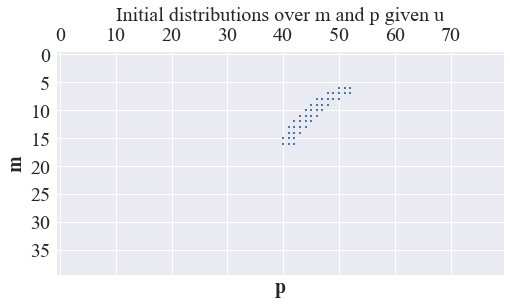

In [24]:
## plot the initial distribution in the first period of life 

plt.title('Initial distributions over m and p given u')
plt.spy(HH.initial_dist_u.reshape(n_m,-1),
       markersize = 2)
plt.xlabel('p')
plt.ylabel('m')

Text(0, 0.5, 'm')

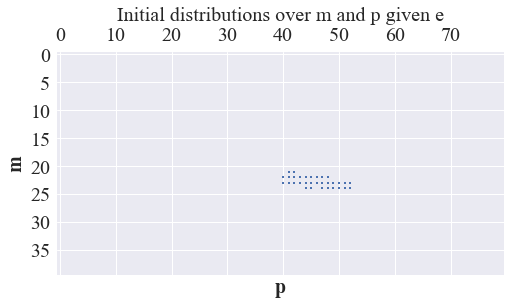

In [25]:
## plot the initial distribution in the first period of life 

plt.title('Initial distributions over m and p given e')
plt.spy(HH.initial_dist_e.reshape(n_m,-1),
       markersize = 2)
plt.xlabel('p')
plt.ylabel('m')

In [26]:
HH.Aggregate()
print('aggregate savings under stationary distribution:', str(HH.A))

aggregate savings under stationary distribution: 9.412480790506265


### Stationary wealth/consumption distribution

In [27]:
share_agents_ap,share_ap = HH.Lorenz(variable='a')

In [28]:
## get the wealth distribution from SCF (net worth)

SCF2016 = pd.read_stata('rscfp2016.dta')
SCF2016 = SCF2016.drop_duplicates(subset=['yy1'])

SCF_wealth, SCF_weights = np.array(SCF2016['networth']), np.array(SCF2016['wgt'])

## get the lorenz curve weights from SCF 
SCF_wealth_sort_id = SCF_wealth.argsort()
SCF_wealth_sort = SCF_wealth[SCF_wealth_sort_id]
SCF_weights_sort = SCF_weights[SCF_wealth_sort_id]
SCF_weights_sort_norm = SCF_weights_sort/SCF_weights_sort.sum()

SCF_share_agents_ap, SCF_share_ap = lorenz_curve(SCF_wealth_sort,
                                                 SCF_weights_sort_norm,
                                                 nb_share_grid = 200)

SCF_profile = pd.read_pickle('data/SCF_age_profile.pkl')

SCF_profile['mv_wealth'] = SCF_profile['av_wealth'].rolling(3).mean()

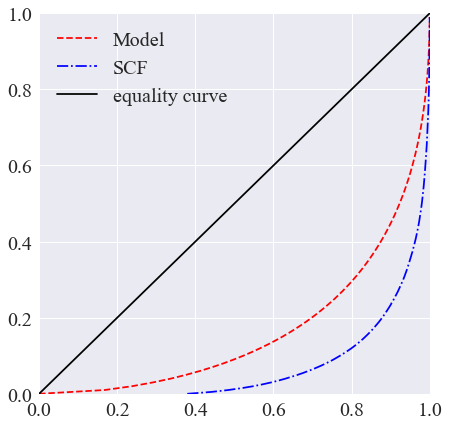

In [29]:
## Lorenz curve of steady state wealth distribution

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(share_agents_ap,share_ap, 'r--',label='Model')
ax.plot(SCF_share_agents_ap,SCF_share_ap, 'b-.',label='SCF')
ax.plot(share_agents_ap,share_agents_ap, 'k-',label='equality curve')
ax.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.savefig('../Graphs/model/lorenz_a_test.png')

/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_22964/1935101778.py:9: RuntimeWarning: invalid value encountered in log
  ax.plot(np.log(ap_grid_dist+1e-5),


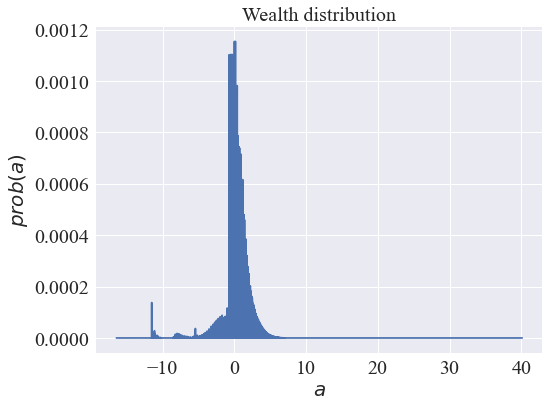

In [30]:
## Wealth distribution 

ap_grid_dist = HH.ap_grid_dist
ap_pdfs_dist = HH.ap_pdfs_dist


fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('Wealth distribution')
ax.plot(np.log(ap_grid_dist+1e-5), 
         ap_pdfs_dist)

ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$prob(a)$')
fig.savefig('../Graphs/model/distribution_a_test.png')


### Life-cycle profile and wealth distribution

In [31]:
HH.AggregatebyAge()

A_life = HH.A_life


/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_22964/21737221.py:8: RuntimeWarning: invalid value encountered in log
  np.log(A_life),
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_22964/21737221.py:13: RuntimeWarning: invalid value encountered in log
  np.min(np.log(A_life)),
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_22964/21737221.py:14: RuntimeWarning: invalid value encountered in log
  np.max(np.log(A_life)),
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


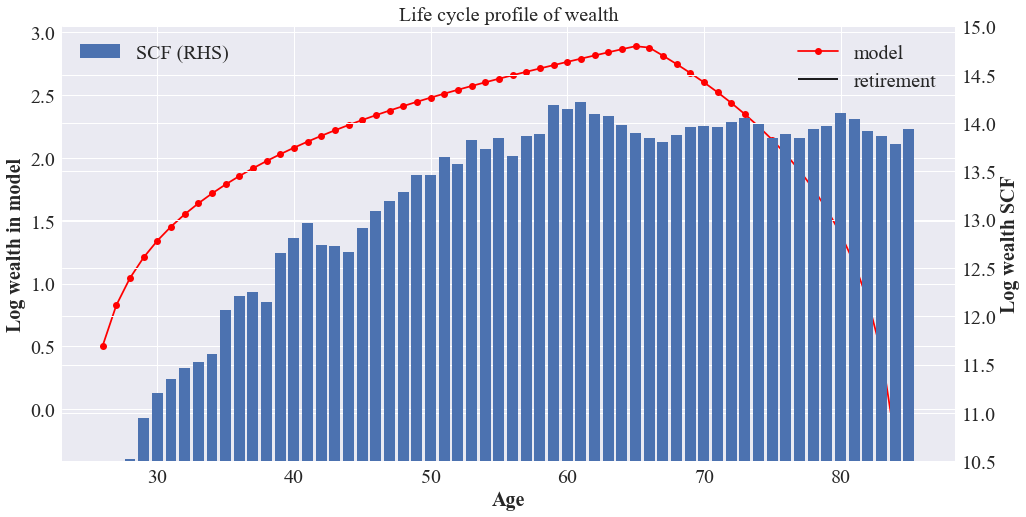

In [32]:
## plot life cycle profile

age_lc = SCF_profile.index

fig, ax = plt.subplots(figsize=(16,8))
plt.title('Life cycle profile of wealth')
ax.plot(age_lc[1:],
       np.log(A_life),
       'r-o',
       label='model')

ax.vlines(lc_mkv.T+25,
          np.min(np.log(A_life)),
          np.max(np.log(A_life)),
          color='k',
          label='retirement'
         )
#ax.set_ylim([-2.0,2.0])

ax2 = ax.twinx()
ax2.set_ylim([10.5,15])
ax2.bar(age_lc[1:],
        np.log(SCF_profile['mv_wealth'][1:]),
       label='SCF (RHS)')

#ax2.plot(age,
#        C_life,
#        'b--',
#        label='consumption (RHS)')

ax.set_xlabel('Age')
ax.set_ylabel('Log wealth in model')
ax2.set_ylabel('Log wealth SCF')
ax.legend(loc=1)
ax2.legend(loc=2)
fig.savefig('../Graphs/model/life_cycle_a_test.png')

In [33]:
## get the within-age distribution 

HH.get_lifecycle_dist()

ap_grid_dist_life,ap_pdfs_dist_life = HH.ap_grid_dist_life,HH.ap_pdfs_dist_life

In [34]:
joy = False
if joy:
    ## create the dataframe to plot distributions over the life cycle 
    ap_pdfs_life = pd.DataFrame(ap_pdfs_dist_life).T
    cp_pdfs_life = pd.DataFrame(cp_pdfs_dist_life).T


    ap_range = list(ap_pdfs_life.index)
    cp_range = list(cp_pdfs_life.index)
    
    ## plot 
    fig, axes = joypy.joyplot(ap_pdfs_life, 
                              kind="values", 
                              x_range=ap_range,
                              figsize=(6,10),
                              title="Wealth distribution over life cycle",
                             colormap=cm.winter)
    fig.savefig('../Graphs/model/life_cycle_distribution_a_test.png')

    
else:
    pass

### General Equilibrium 

In [35]:
## initialize a market and solve the equilibrium 


market_OLG_mkv = Market_OLG_mkv(households = HH,
                                production = production)

market_OLG_mkv.get_equilibrium_k()


target KY 3.0
target W 1.0
steady state emp pop 0.6596938662712266
Normalized Z 0.9100806239574033
Normalized K 4.477611940298525
W 1.0000000000000009
KY 3.0000000000000084
R 1.0849999999999997
Labor force 0.6596938662712266
Capital stock 6.0
Wage rate 1.263460230249501
Real interest rate 1.0434213925813844
Tax rate 0.004962775894405833
Social security tax rate 0.33921480819878
time taken to get SS dist:15.35200309753418
Induced capital stock 12.93213823548651
Labor force 0.6596938662712266
Capital stock 12.93213823548651
Wage rate 1.627881828267664
Real interest rate 1.0159010182642043
Tax rate 0.004962775894405833
Social security tax rate 0.33921480819878
time taken to get SS dist:15.245264768600464
Induced capital stock 7.379544020860525
Labor force 0.6596938662712266
Capital stock 9.849064504018347
Wage rate 1.487962573500165
Real interest rate 1.0240883697408603
Tax rate 0.004962775894405833
Social security tax rate 0.33921480819878
time taken to get SS dist:15.019646167755127
Ind

In [36]:
market_OLG_mkv.get_equilibrium_dist()

SS Capital stock 9.30183018120411
SS Wage Rate 1.460155934138263
SS Real interest rate 1.0260049603751273
time taken to get SS dist:98.64478611946106


/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_22964/4752161.py:8: RuntimeWarning: invalid value encountered in log
  np.log(market_OLG_mkv.households.A_life)[:-1],


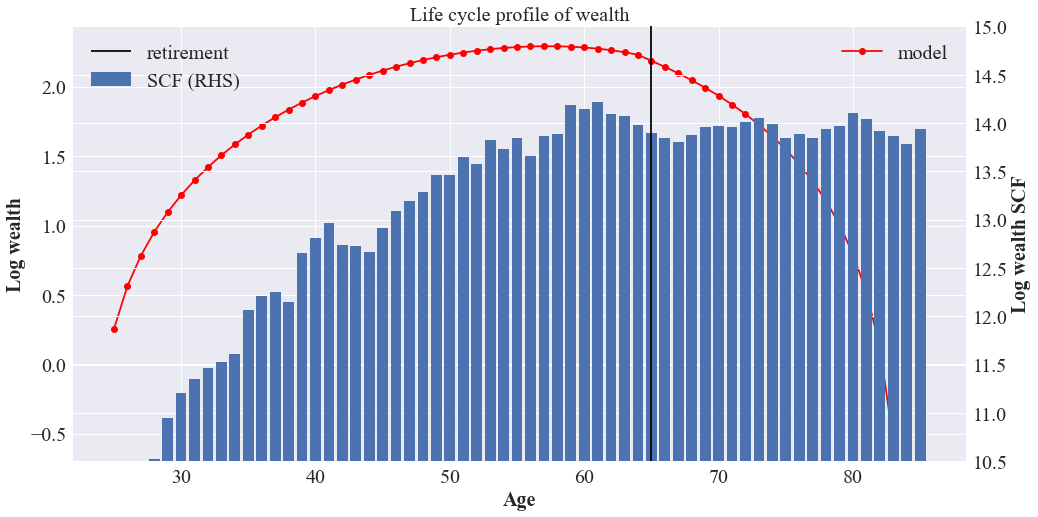

In [37]:
## plot life cycle profile

age_lc = SCF_profile.index

fig, ax = plt.subplots(figsize=(16,8))
plt.title('Life cycle profile of wealth')
ax.plot(age_lc[:-2],
        np.log(market_OLG_mkv.households.A_life)[:-1],
       'r-o',
       label='model')


ax2 = ax.twinx()
ax2.set_ylim([10.5,15])
ax2.vlines(lc_mkv.T+25,
          10.5,
          15,
          color='k',
          label='retirement')

ax2.bar(age_lc,
        np.log(SCF_profile['mv_wealth']),
       #'k--',
       label='SCF (RHS)')

#ax2.plot(age,
#        C_life,
#        'b--',
#        label='consumption (RHS)')

ax.set_xlabel('Age')
ax.set_ylabel('Log wealth')
ax2.set_ylabel('Log wealth SCF')
ax.legend(loc=1)
ax2.legend(loc=2)
fig.savefig('../Graphs/model/life_cycle_a_eq.png')

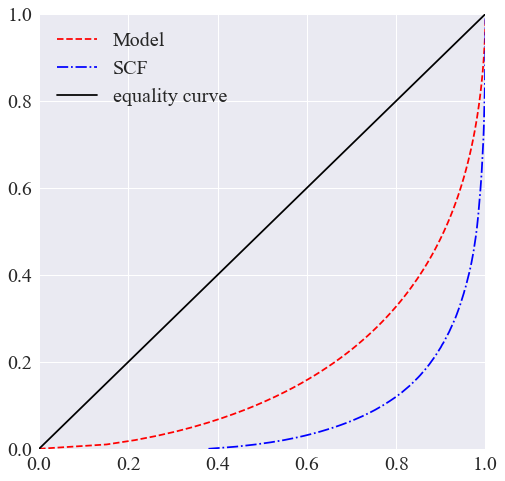

In [38]:
## compute things needed for lorenz curve plot of asset accumulation 

share_agents_ap, share_ap = market_OLG_mkv.households.Lorenz(variable='a')

## Lorenz curve of steady state wealth distribution

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(share_agents_ap,share_ap, 'r--',label='Model')
ax.plot(SCF_share_agents_ap,SCF_share_ap, 'b-.',label='SCF')
ax.plot(share_agents_ap,share_agents_ap, 'k-',label='equality curve')
ax.legend()
plt.xlim([0,1])
plt.ylim([0,1])
fig.savefig('../Graphs/model/lorenz_curve_a_eq.png')


/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_22964/979394324.py:5: RuntimeWarning: invalid value encountered in log
  ax.plot(np.log(market_OLG_mkv.households.ap_grid_dist+1e-5),


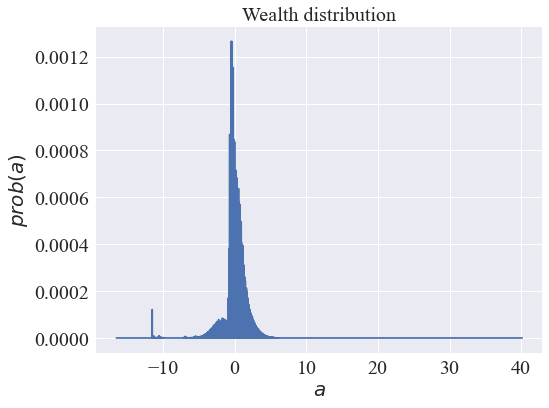

In [39]:
## Wealth distribution 

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('Wealth distribution')
ax.plot(np.log(market_OLG_mkv.households.ap_grid_dist+1e-5), 
         market_OLG_mkv.households.ap_pdfs_dist)
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$prob(a)$')
fig.savefig('../Graphs/model/distribution_a_eq.png')


## Model Comparison

## compare different models 

In [40]:
def solve_1model(model,
                m_star,
                σ_star,
                n_m = 30,
                n_p = 40,
                model_name = 'model',
                ge = True):
    HH_this = HH_OLG_Markov(model = model)
    HH_this.define_distribution_grid(num_pointsM = n_m, 
                                    num_pointsP = n_p)
    HH_this.ComputeSSDist(ms_star = m_star,
                          σs_star = σ_star)
    HH_this.Aggregate()
    print('aggregate savings under stationary distribution:', str(HH_this.A))

    ## lorenz 
    share_agents_ap_this,share_ap_this = HH_this.Lorenz(variable='a')

    ## gini in pe
    gini_this_pe = gini(share_agents_ap_this,
                     share_ap_this)

    ## life cycle 

    HH_this.AggregatebyAge()

    A_life_this = HH_this.A_life

    ## distribution 
    
    if ge:

        ## general equilibrium 

        market_OLG_mkv_this = Market_OLG_mkv(households = HH_this,
                                            production = production)

        market_OLG_mkv_this.get_equilibrium_k()
        market_OLG_mkv_this.get_equilibrium_dist()

        ## aggregate 


        ## life cycle 

        ## lorenz 
        share_agents_ap_ge_this, share_ap_ge_this = market_OLG_mkv_this.households.Lorenz(variable='a')

        ## gini in ge

        gini_this_ge = gini(share_agents_ap_ge_this,
                         share_ap_ge_this)
        
        model_dct =  {'A_pe':HH_this.A,
                    'A_life_pe': HH_this.A_life,
                    'share_agents_ap_pe':share_agents_ap_this,
                    'share_ap_pe':share_ap_this,
                   'ap_grid_dist_pe':HH_this.ap_grid_dist,
                    'ap_pdfs_dist_pe':HH_this.ap_pdfs_dist,
                     'gini_pe':gini_this_pe,
                    'A_ge':market_OLG_mkv_this.households.A,
                    'A_life_ge':market_OLG_mkv_this.households.A_life,
                    'share_agents_ap_ge':share_agents_ap_ge_this,
                    'share_ap_ge':share_ap_ge_this,
                    'ap_grid_dist_ge':market_OLG_mkv_this.households.ap_grid_dist,
                    'ap_pdfs_dist_ge':market_OLG_mkv_this.households.ap_pdfs_dist,
                    'gini_ge':gini_this_ge
                   }
    
    else:
        model_dct =  {'A_pe':HH_this.A,
                    'A_life_pe': HH_this.A_life,
                    'share_agents_ap_pe':share_agents_ap_this,
                    'share_ap_pe':share_ap_this,
                   'ap_grid_dist_pe':HH_this.ap_grid_dist,
                    'ap_pdfs_dist_pe':HH_this.ap_pdfs_dist,
                     'gini_pe':gini_this_pe
                   }

    
    ## save it as a pkl
    import pickle
    pickle.dump(model_dct,open('./model_solutions/'+model_name+'.pkl','wb'))
    
def solve_models(model_list,
                   ms_star_list,
                   σs_star_list,
                    model_name_list):
    
    
    ## loop over different models 
    for k, model in enumerate(model_list):
        print('Solving Model '+str(k))
        print('\n')
        solve_1model(model,
                    ms_star_list[k],
                    σs_star_list[k],
                     model_name = model_name_list[k])

In [41]:
## solve a list of models 
solve_models(models,
             ms_stars,
             σs_stars,
            model_name_list = model_names
            )

Solving Model 0


time taken to get SS dist:31.99337410926819
aggregate savings under stationary distribution: 0.9354723440483101
target KY 3.0
target W 1.0
steady state emp pop 0.6596938662712266
Normalized Z 0.9100806239574348
Normalized K 2.9538531325550808
W 0.9999999999997382
KY 2.999999999998093
R 1.0850000000000701
Labor force 0.6596938662712266
Capital stock 6.0
Wage rate 1.2634602302495446
Real interest rate 1.0434213925813869
Tax rate 0.004962775894405833
Social security tax rate 0.33921480819878
time taken to get SS dist:15.054894924163818
Induced capital stock 12.932138235487312
Labor force 0.6596938662712266
Capital stock 12.932138235487312
Wage rate 1.6278818282677534
Real interest rate 1.015901018264204
Tax rate 0.004962775894405833
Social security tax rate 0.33921480819878
time taken to get SS dist:14.943135976791382
Induced capital stock 7.379544020860604
Labor force 0.6596938662712266
Capital stock 9.849064504018768
Wage rate 1.4879625735002375
Real interest rate 1.02

time taken to get SS dist:14.931559801101685
Induced capital stock 9.226683569052856
Labor force 0.6596938662712266
Capital stock 9.226683569052856
Wage rate 1.4562526223122496
Real interest rate 1.026282911913272
Tax rate 0.004962775894405833
Social security tax rate 0.33921480819878
time taken to get SS dist:14.960124969482422
Induced capital stock 9.229655370873383
Labor force 0.6596938662712266
Capital stock 9.228593045589209
Wage rate 1.4563520687550668
Real interest rate 1.0262758023792227
Tax rate 0.004962775894405833
Social security tax rate 0.33921480819878
time taken to get SS dist:14.961533069610596
Induced capital stock 9.228592615205189
Labor force 0.6596938662712266
Capital stock 9.228592615205189
Wage rate 1.4563520463420165
Real interest rate 1.0262758039813902
Tax rate 0.004962775894405833
Social security tax rate 0.33921480819878
time taken to get SS dist:14.973834991455078
Induced capital stock 9.228592854689433
Labor force 0.6596938662712266
Capital stock 9.22859276

/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_22964/3541632730.py:41: RuntimeWarning: invalid value encountered in log
  np.log(model_solution['A_life_pe']),
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_22964/3541632730.py:41: RuntimeWarning: invalid value encountered in log
  np.log(model_solution['A_life_pe']),
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_22964/3541632730.py:41: RuntimeWarning: invalid value encountered in log
  np.log(model_solution['A_life_pe']),
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_22964/3541632730.py:73: RuntimeWarning: invalid value encountered in log
  ax.plot(np.log(model_solution['ap_grid_dist_pe']+1e-5),
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_22964/3541632730.py:115: RuntimeWarning: invalid value encountered in log
  np.log(model_solution['A_life_ge'])[:-1],
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_22964/3541632730.py:115: RuntimeWarning: invalid value encoun

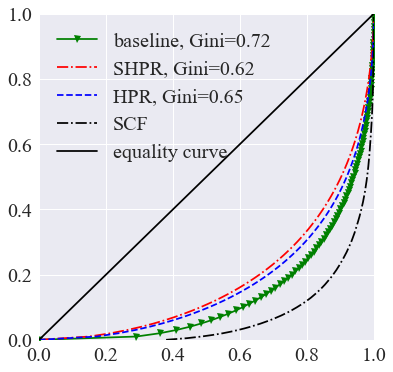

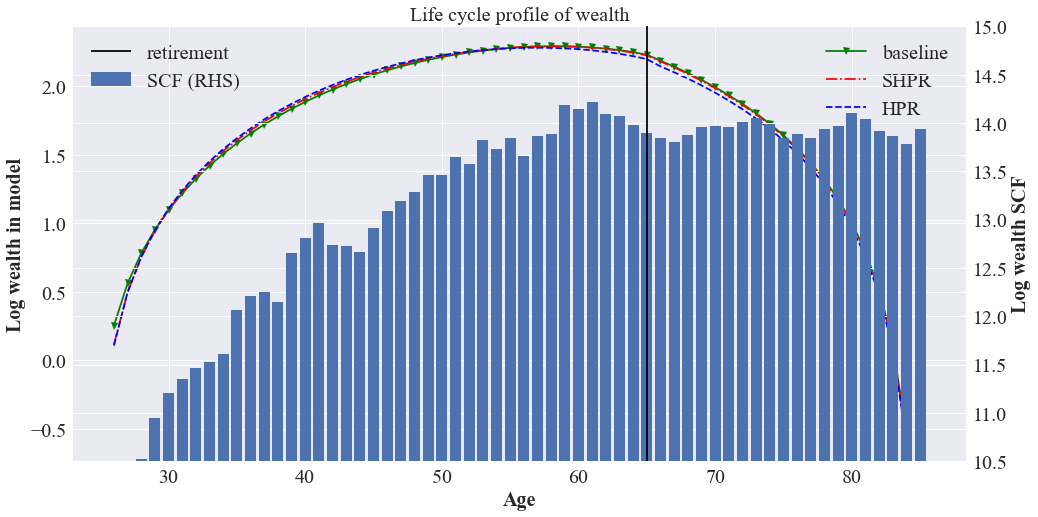

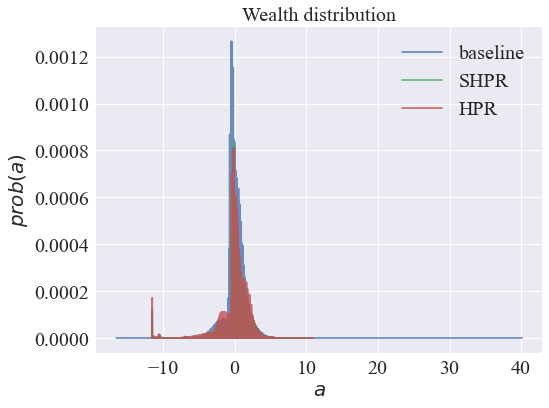

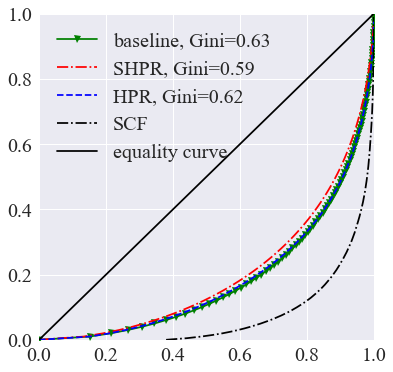

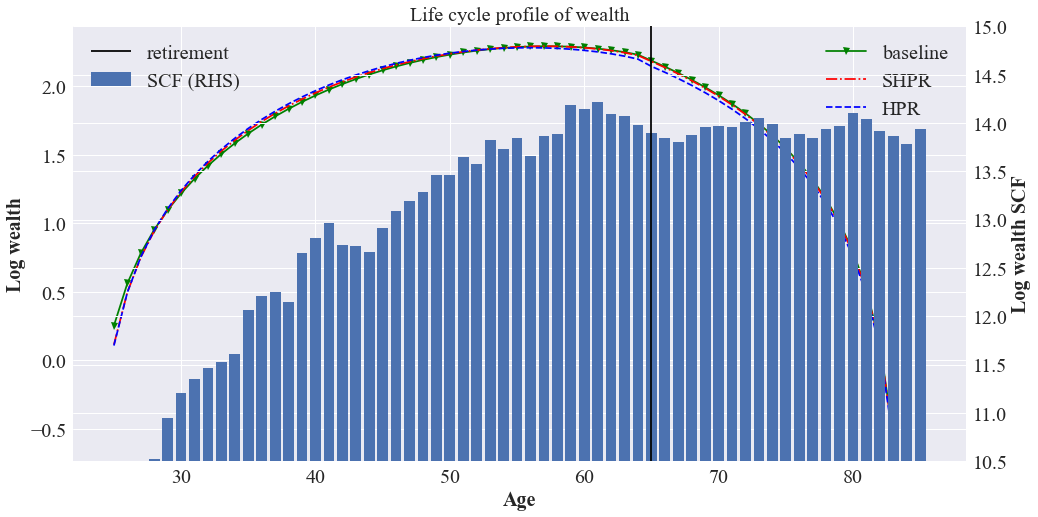

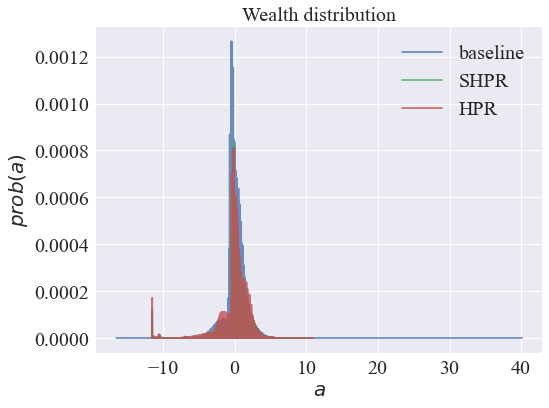

In [42]:
## plot results from different models

line_patterns =['g-v',
                'r-.',
                'b--',
                'y.'
                ]

## Lorenz curve of steady state wealth distribution

fig, ax = plt.subplots(figsize=(6,6))
for k,model in enumerate(models):
    model_solution = pickle.load(open('./model_solutions/'+ model_names[k]+'.pkl','rb'))
    ax.plot(model_solution['share_agents_ap_pe'],
            model_solution['share_ap_pe'],
            line_patterns[k],
            label = model_names[k]+', Gini={:.2f}'.format(model_solution['gini_pe']))
ax.plot(SCF_share_agents_ap,
        SCF_share_ap, 'k-.',
        label='SCF')
ax.plot(model_solution['share_agents_ap_pe'],
        model_solution['share_agents_ap_pe'], 
        'k-',
        label='equality curve')
ax.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.savefig('../Graphs/model/lorenz_a_compare_pe.png')


## life cycle

age_lc = SCF_profile.index

fig, ax = plt.subplots(figsize=(16,8))
plt.title('Life cycle profile of wealth')

for k,model in enumerate(models):
    model_solution = pickle.load(open('./model_solutions/'+ model_names[k]+'.pkl','rb'))
    ax.plot(age_lc[1:],
           np.log(model_solution['A_life_pe']),
           line_patterns[k],
           label= model_names[k])
#ax.set_ylim([-0.5,3.5])

ax2 = ax.twinx()
ax2.set_ylim([10.5,15])
ax2.vlines(lc_mkv.T+25,
          10.5,
          15,
          color='k',
          label='retirement'
         )
ax2.bar(age_lc[1:],
        np.log(SCF_profile['mv_wealth'][1:]),
       label='SCF (RHS)')

ax.set_xlabel('Age')
ax.set_ylabel('Log wealth in model')
ax2.set_ylabel('Log wealth SCF')
ax.legend(loc=1)
ax2.legend(loc=2)
fig.savefig('../Graphs/model/life_cycle_a_compare_pe.png')



## wealth distributions in pe

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('Wealth distribution')
for k, model in enumerate(models):
    model_solution = pickle.load(open('./model_solutions/'+ model_names[k]+'.pkl','rb'))
    ax.plot(np.log(model_solution['ap_grid_dist_pe']+1e-5),
            model_solution['ap_pdfs_dist_pe'],
            label=model_names[k],
           alpha = 0.8)
ax.set_xlabel(r'$a$')
ax.legend(loc=0)
ax.set_ylabel(r'$prob(a)$')

fig.savefig('../Graphs/model/distribution_a_compare_pe.png')


## lorenz curve in ge

fig, ax = plt.subplots(figsize=(6,6))
for k,model in enumerate(models):
    model_solution = pickle.load(open('./model_solutions/'+ model_names[k]+'.pkl','rb'))
    ax.plot(model_solution['share_agents_ap_ge'],
            model_solution['share_ap_ge'],
            line_patterns[k],
            label = model_names[k]+', Gini={:.2f}'.format(model_solution['gini_ge']))

ax.plot(SCF_share_agents_ap,
        SCF_share_ap, 'k-.',
        label='SCF')
ax.plot(model_solution['share_agents_ap_ge'],
        model_solution['share_agents_ap_ge'], 
        'k-',
        label='equality curve')
ax.legend()
plt.xlim([0,1])
plt.ylim([0,1])
fig.savefig('../Graphs/model/lorenz_a_compare_ge.png')


## life cycle profile in ge

fig, ax = plt.subplots(figsize=(16,8))
plt.title('Life cycle profile of wealth')

for k, model in enumerate(models):
    model_solution = pickle.load(open('./model_solutions/'+ model_names[k]+'.pkl','rb'))
    ax.plot(age_lc[:-2],
            np.log(model_solution['A_life_ge'])[:-1],
            line_patterns[k],
           label = model_names[k])

#ax.set_ylim([-0.5,3.5])

ax2 = ax.twinx()
ax2.set_ylim([10.5,15])
ax2.vlines(lc_mkv.T+25,
          10.5,
          15,
          color='k',
          label='retirement')
ax2.bar(age_lc,
        np.log(SCF_profile['mv_wealth']),
       #'k--',
       label='SCF (RHS)')

ax.set_xlabel('Age')
ax.set_ylabel('Log wealth')
ax2.set_ylabel('Log wealth SCF')
ax.legend(loc=1)
ax2.legend(loc=2)
fig.savefig('../Graphs/model/life_cycle_a_compare_ge.png')


## wealth distributions in ge

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('Wealth distribution')
for k, model in enumerate(models):
    model_solution = pickle.load(open('./model_solutions/'+ model_names[k]+'.pkl','rb'))
    ax.plot(np.log(model_solution['ap_grid_dist_ge']+1e-5),
            model_solution['ap_pdfs_dist_ge'],
            label=model_names[k],
            alpha = 0.8)
ax.set_xlabel(r'$a$')
ax.legend(loc=0)
ax.set_ylabel(r'$prob(a)$')

fig.savefig('../Graphs/model/distribution_a_compare_ge.png')